In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
from Bio.Seq import Seq
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
from matplotlib import collections  as mc
from scipy.special import expit

# DMS data

Single mutant scores

In [2]:
dms_df = pd.read_csv("../results/final_variant_scores/final_variant_scores.csv", dtype=dict(position_IMTG=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMTG.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMTG)]
dms_df

target wildtype  position  position_IMTG chain mutant  mutation  \
0     CGG_naive        E         1              1     H      A    E1(H)A   
1     CGG_naive        E         1              1     H      C    E1(H)C   
2     CGG_naive        E         1              1     H      D    E1(H)D   
3     CGG_naive        E         1              1     H      E    E1(H)E   
4     CGG_naive        E         1              1     H      F    E1(H)F   
...         ...      ...       ...            ...   ...    ...       ...   
4695  CGG_naive        R       235            124     L      S  R124(L)S   
4696  CGG_naive        R       235            124     L      T  R124(L)T   
4697  CGG_naive        R       235            124     L      V  R124(L)V   
4698  CGG_naive        R       235            124     L      W  R124(L)W   
4699  CGG_naive        R       235            124     L      Y  R124(L)Y   

     codon single_nt      bind  ...      expr  delta_expr  n_bc_expr  \
0      GAG      True  10.48829  ...  10.44614    -0.00453       19.0   
1      GAG     False  10.44477  ...  10.32364    -0.12703       20.0   
2      GAG      True  10.42771  ...  10.51618     0.06551       16.0   
3      GAG      True  10.45719  ...  10.45067     0.00000    21170.0   
4      GAG     False  10.51899  ...  10.33163    -0.11904       24.0   
...    ...       ...       ...  ...       ...         ...        ...   
4695   CGT      True  10.44756  ...  10.54313     0.09246       39.0   
4696   CGT     False  10.43023  ...  10.53860     0.08793       36.0   
4697   CGT     False  10.38231  ...  10.48707     0.03640       27.0   
4698   CGT     False  10.48219  ...  10.38698    -0.06369       33.0   
4699   CGT     False  10.47297  ...  10.48454     0.03387       34.0   

      n_libs_expr      psr  delta_psr  n_bc_psr  n_libs_psr     WT   site  
0             2.0  6.78608   -0.07452      17.0         2.0  False  H-001  
1             2.0  7.44234    0.58174      17.0         2.0  False  H-001  
2             2.0  6.95940    0.09880      13.0         2.0  False  H-001  
3             2.0  6.86060    0.00000   18910.0         2.0   True  H-001  
4             2.0  6.91372    0.05313      21.0         2.0  False  H-001  
...           ...      ...        ...       ...         ...    ...    ...  
4695          2.0  6.93925    0.07866      33.0         2.0  False  L-124  
4696          2.0  6.88956    0.02896      34.0         2.0  False  L-124  
4697          2.0  6.78160   -0.07899      24.0         2.0  False  L-124  
4698          2.0  6.91474    0.05415      29.0         2.0  False  L-124  
4699          2.0  6.96378    0.10318      32.0         2.0  False  L-124  

[4400 rows x 23 columns]

Position maps for scFv

In [3]:
pos_df = pd.read_csv("../data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()))
# remove linker sites
pos_df = pos_df[pos_df.chain != "link"]
pos_df

site_scFv amino_acid chain  site KI_codon
0            1          E     H     1      GAG
1            2          V     H     2      GTG
2            3          Q     H     3      CAG
3            4          L     H     4      CTT
4            5          Q     H     5      CAG
..         ...        ...   ...   ...      ...
230        231          L     L   120      CTA
231        232          E     L   121      GAA
232        233          I     L   122      ATA
233        234          K     L   123      AAA
234        235          R     L   124      CGT

[220 rows x 5 columns]

In [4]:
igh_pos_map = pos_df[pos_df.chain == "H"]
igk_pos_map = pos_df[pos_df.chain == "L"].reset_index(drop=True)

## Heatmaps indicating inaccessible first-step mutations

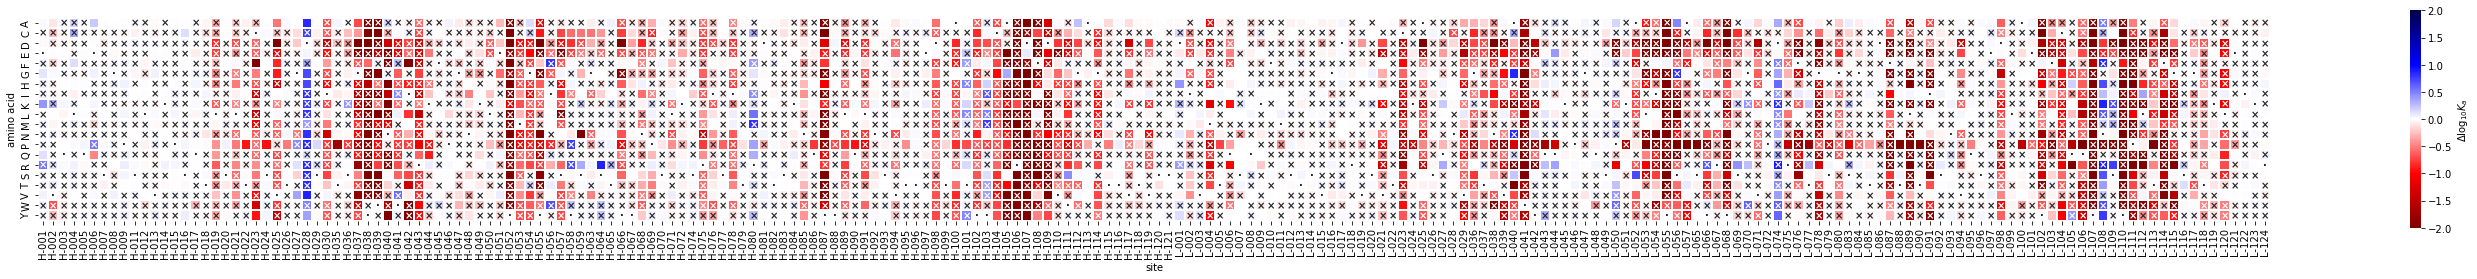

In [5]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmin = -2 # dms_df.delta_bind.min()
vmax = 2 #dms_df.delta_bind.max()

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig("output/plots/bind_heatmap.pdf")
plt.show()

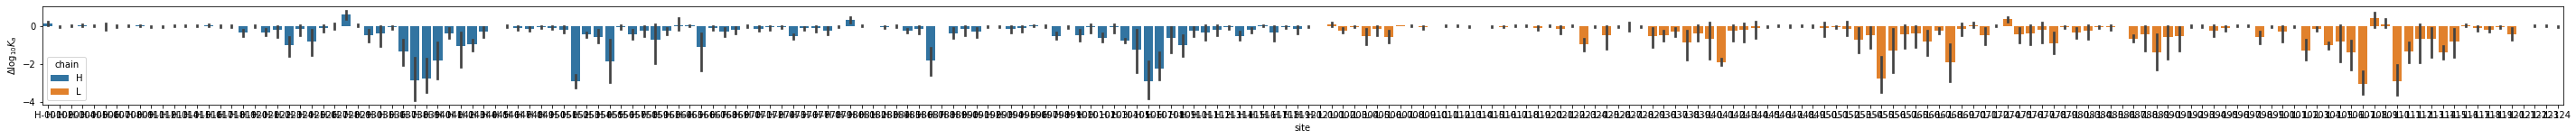

In [6]:
plt.figure(figsize=(50, 2))
sns.barplot(data=dms_df[(~dms_df.WT) & dms_df.single_nt], x="site", y="delta_bind", hue="chain", dodge=False)
plt.ylabel(r"$\Delta\log_{10} K_a$")
plt.savefig("output/plots/bind_boxplot.pdf")
plt.show()

# Replay tree data

In [7]:
trees = {f.split("/")[2]: pickle.load(open(f, "rb")) for f in glob.glob("data/*/*/gctree.out.inference.1.p")}

In [8]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

## Functions for color mapping $\Delta\log K_a$ on trees

- Warm colors indicate $\Delta\log_{10} K_a < 0$
- Cool colors indicate $\Delta\log_{10} K_a > 0$

In [178]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

def bind_colormap(tree, vmin, vmax):
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

    cmap = cm.get_cmap("coolwarm_r")
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    colormap = {}

    for node in tree.tree.traverse():
        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map.site, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map.site, "(L)")

        sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()

        colormap[node.name] = to_hex(cmap(norm(sum_delta_bind)))

    return colormap

gc31HK


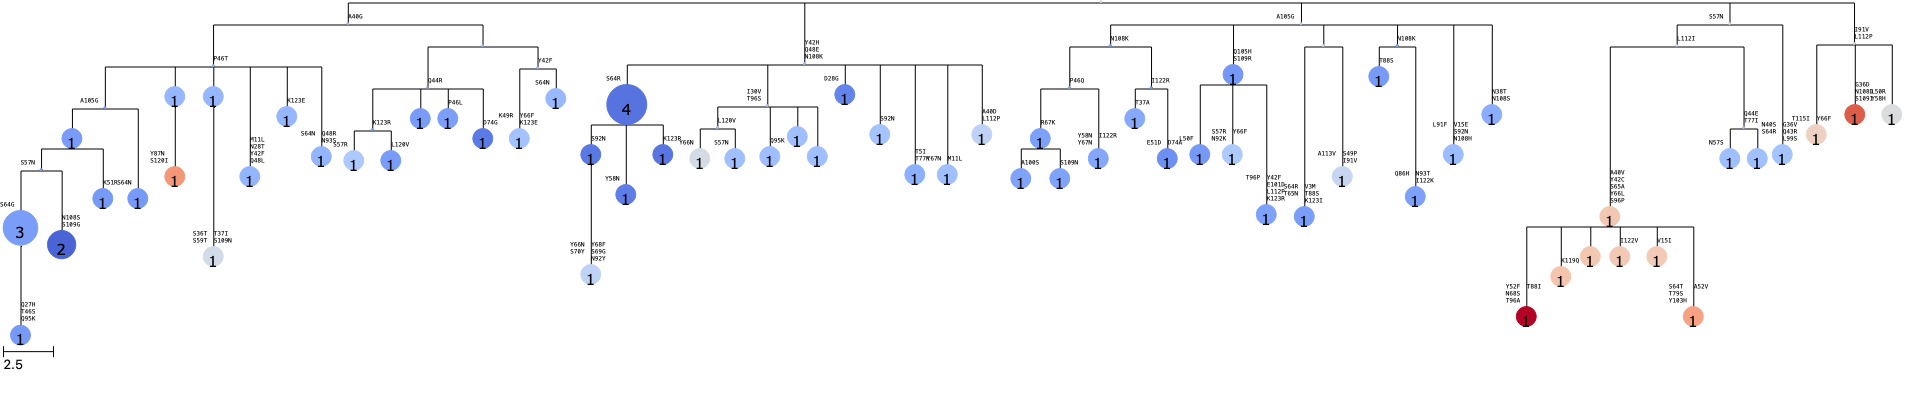

gc50HK


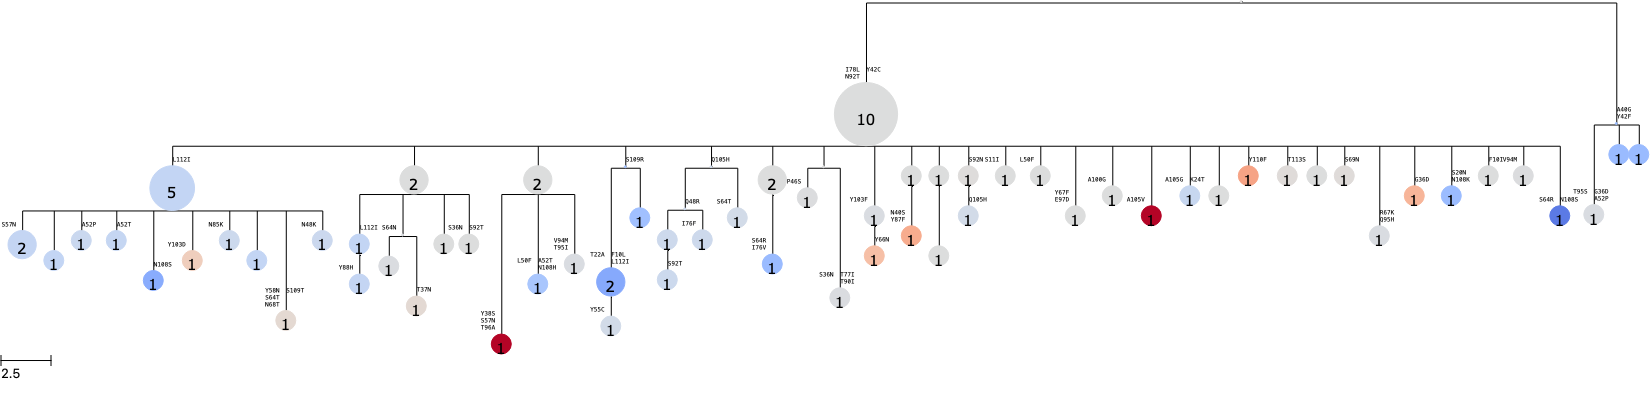

gc59HK


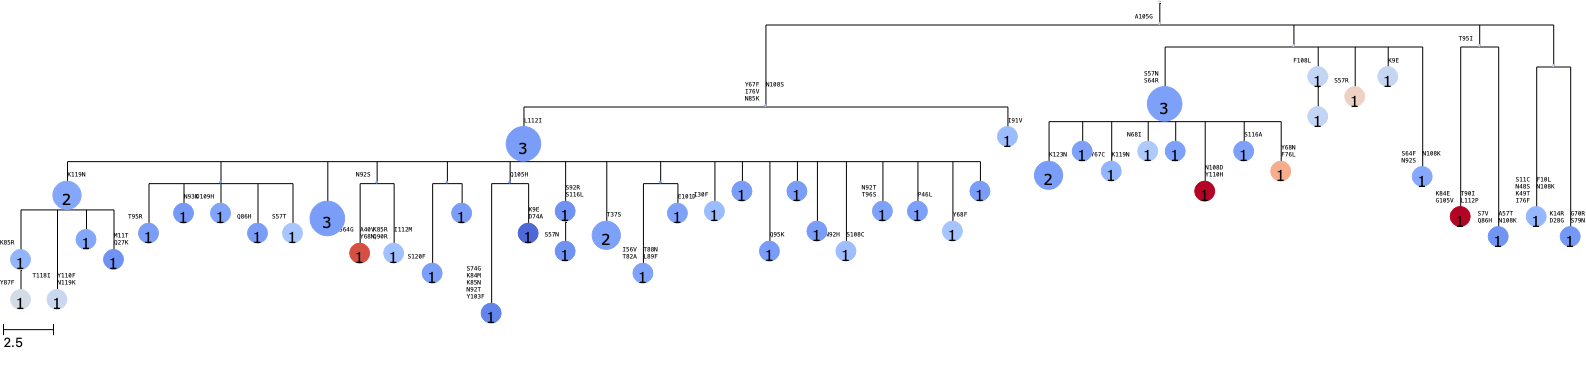

gc17HK


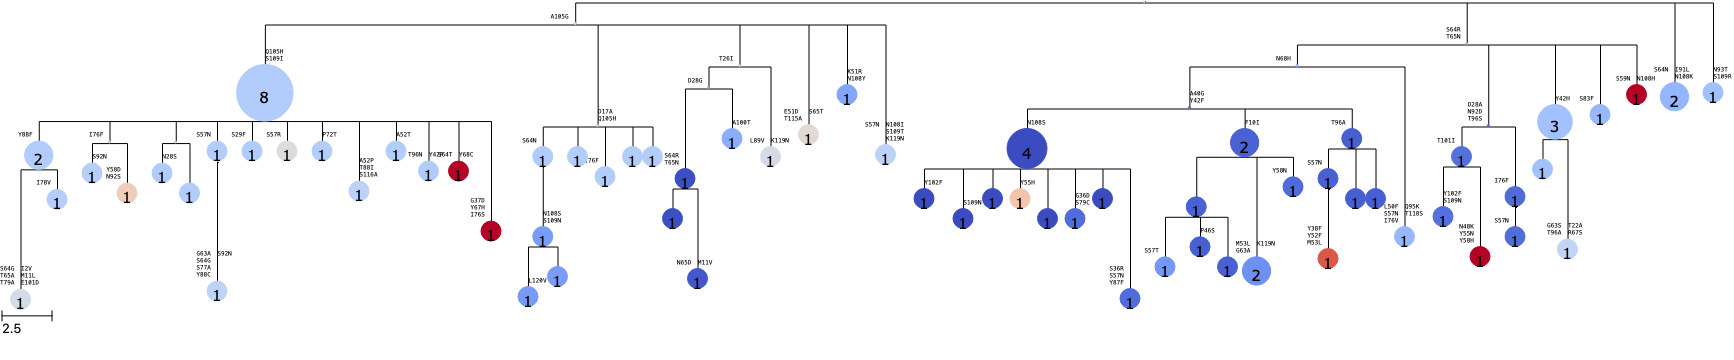

gc56HK


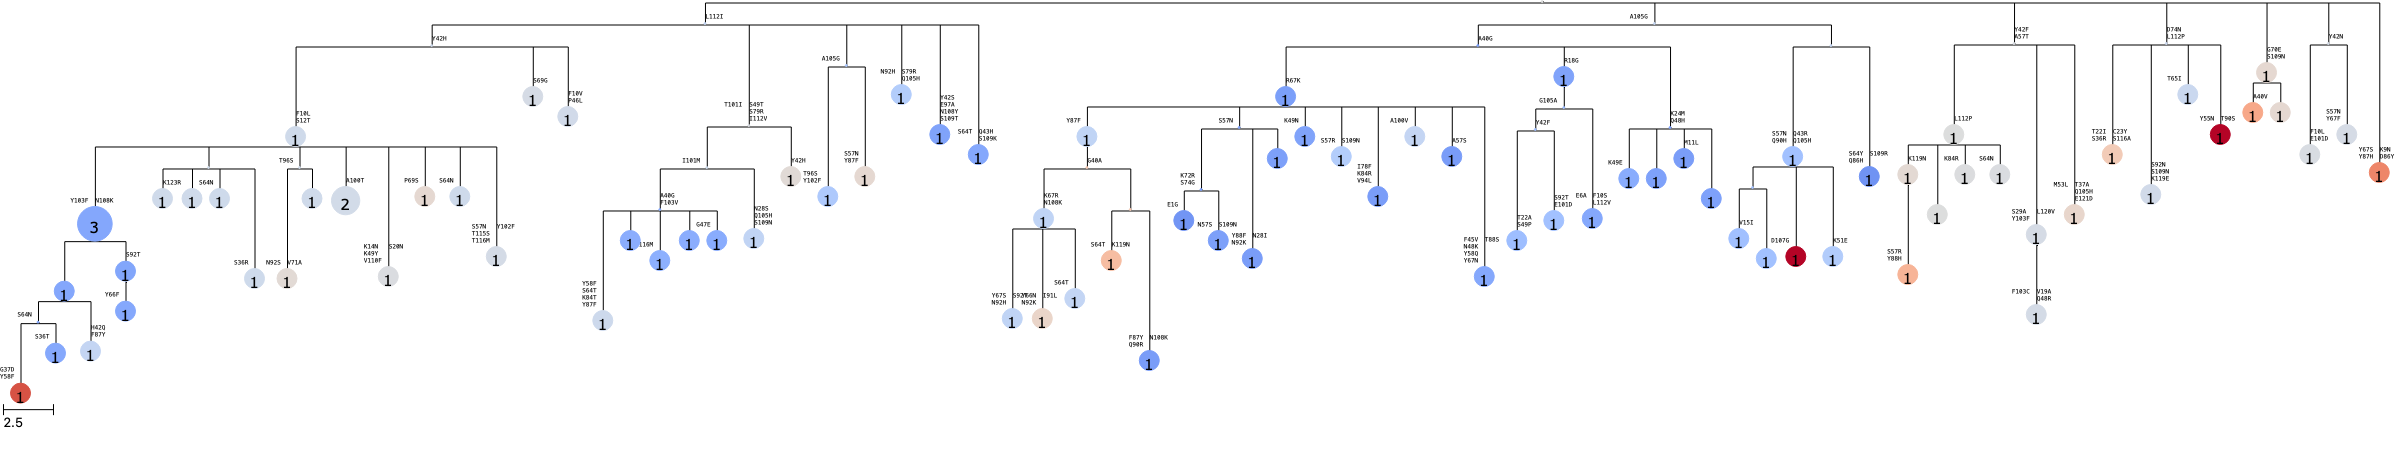

gc39HK


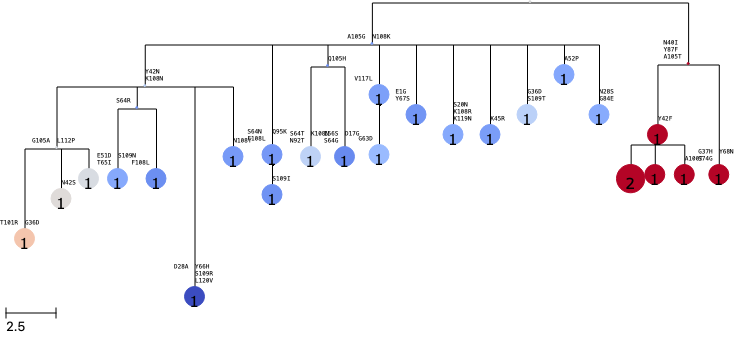

gc77HK


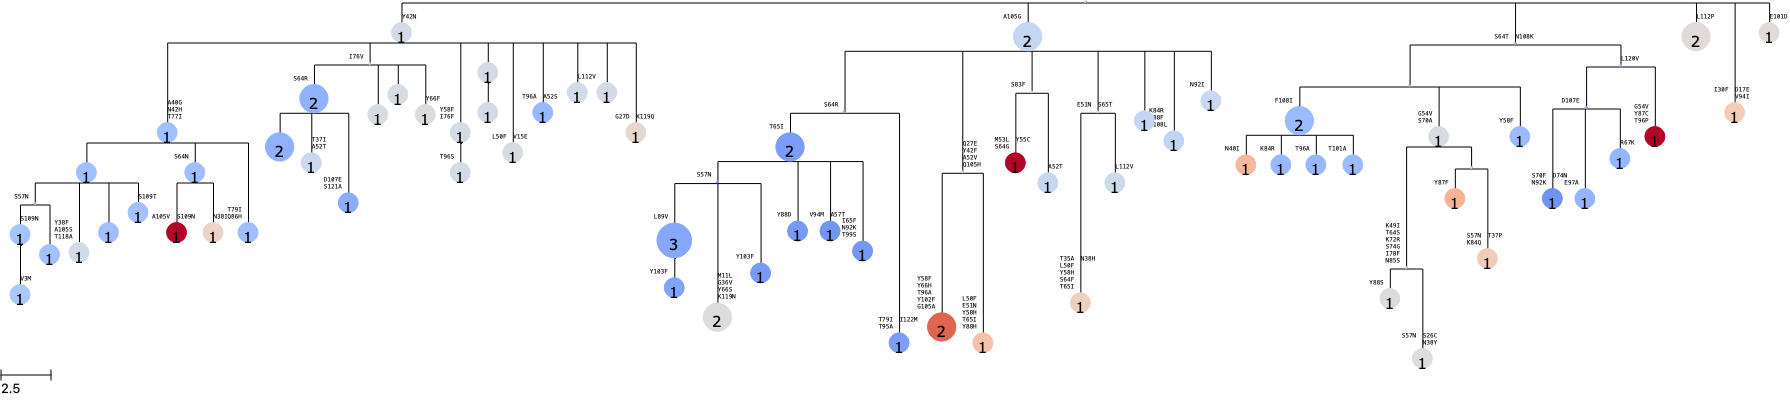

gc16HK


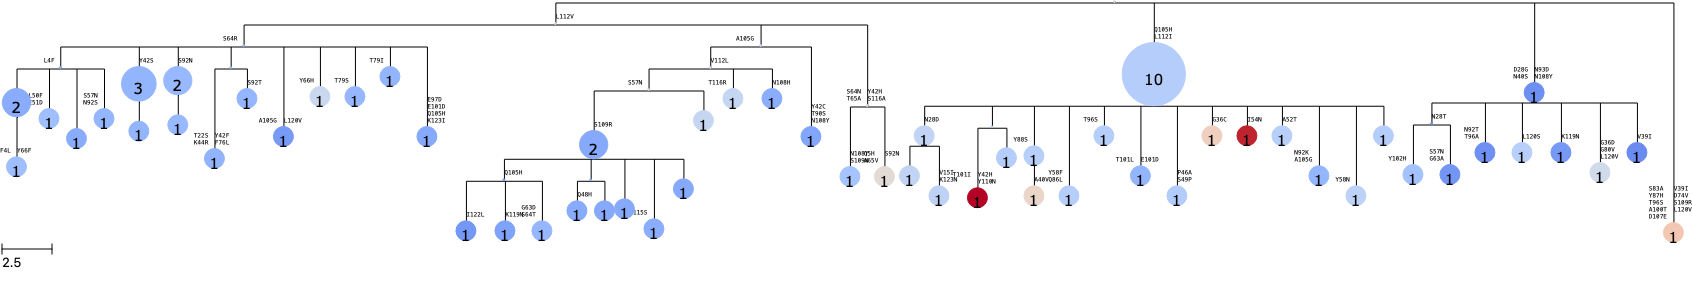

gc46HK


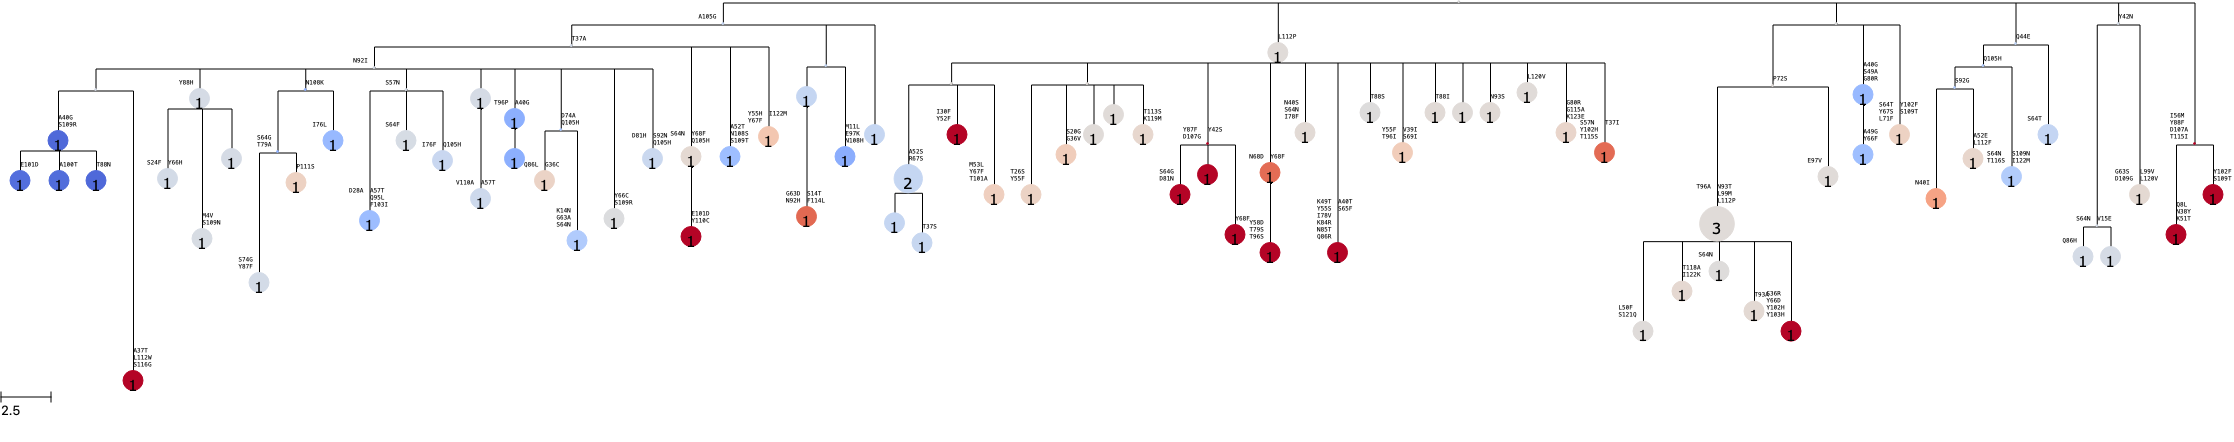

gc30HK


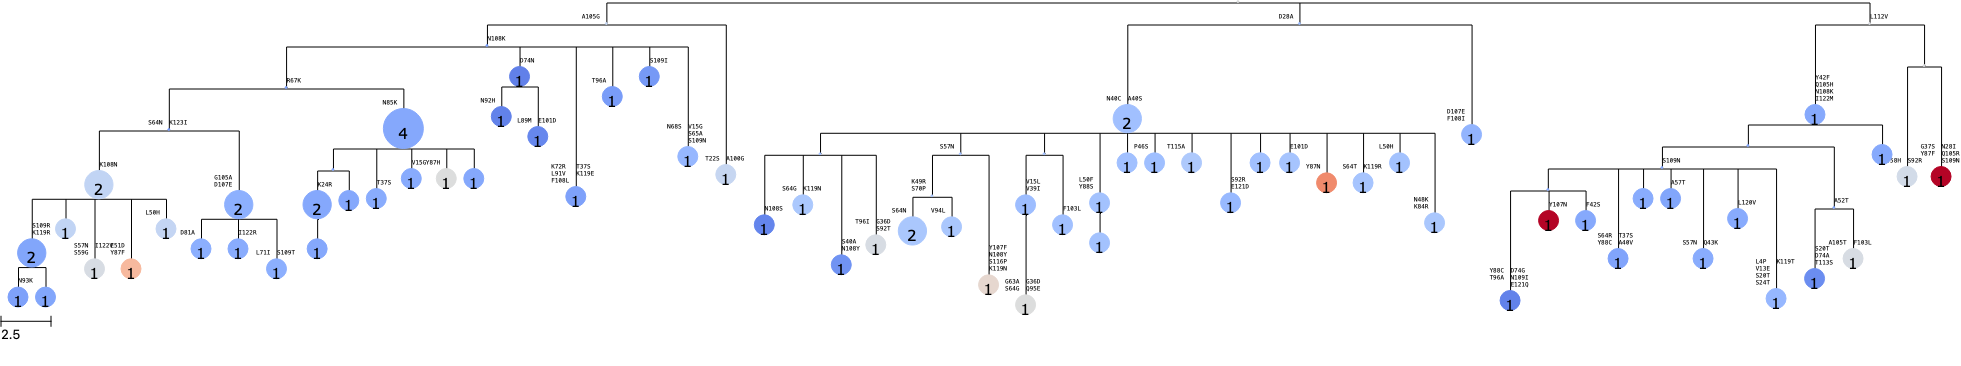

gc14HK


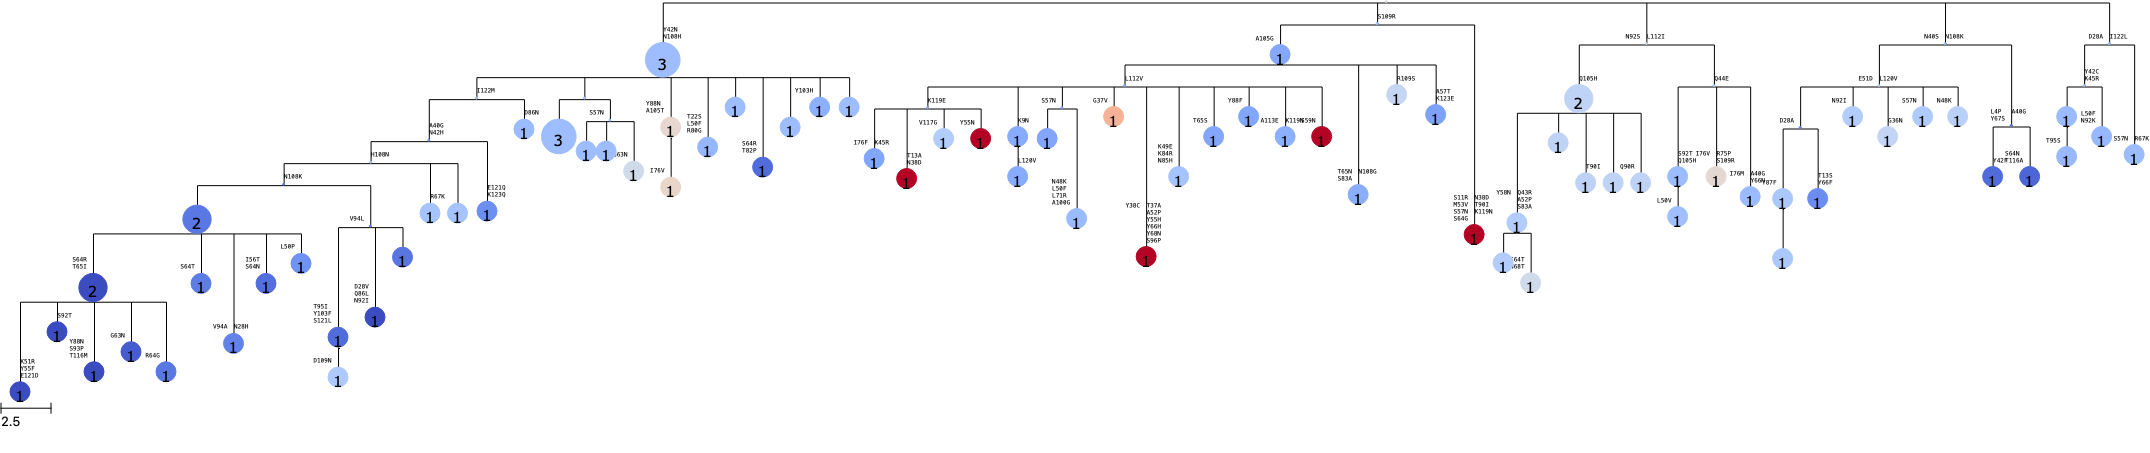

gc6HK


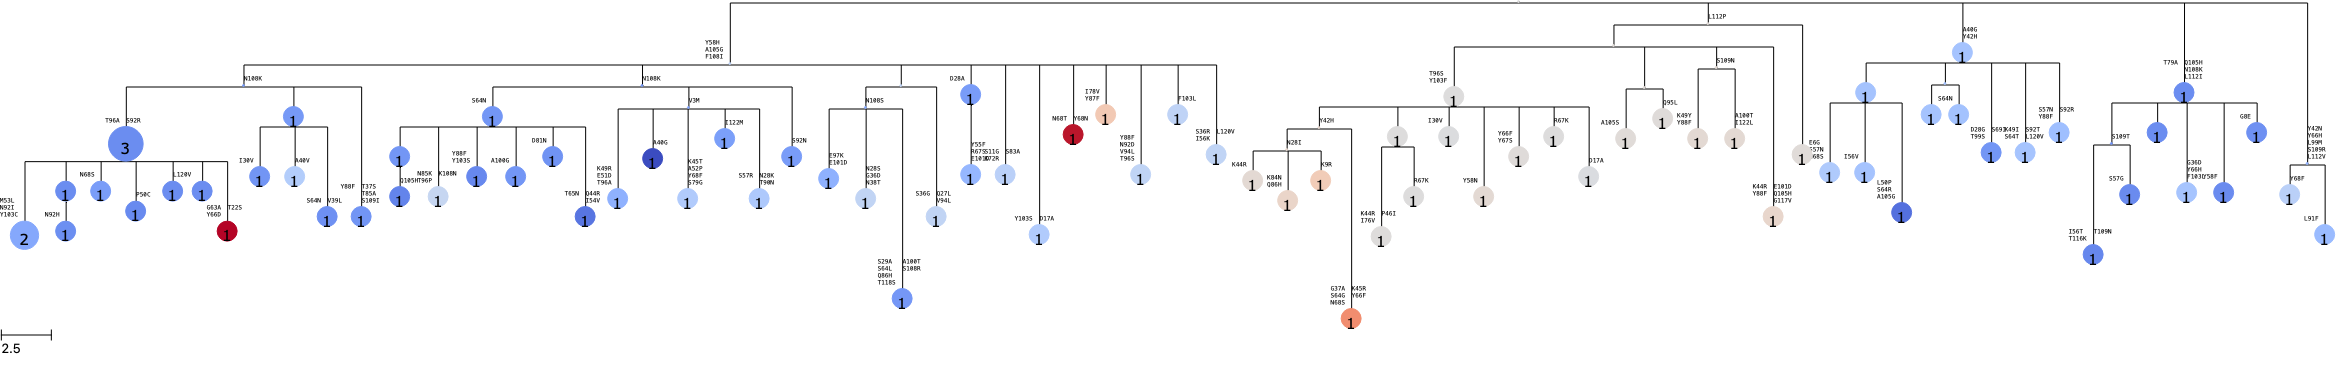

gc2HK


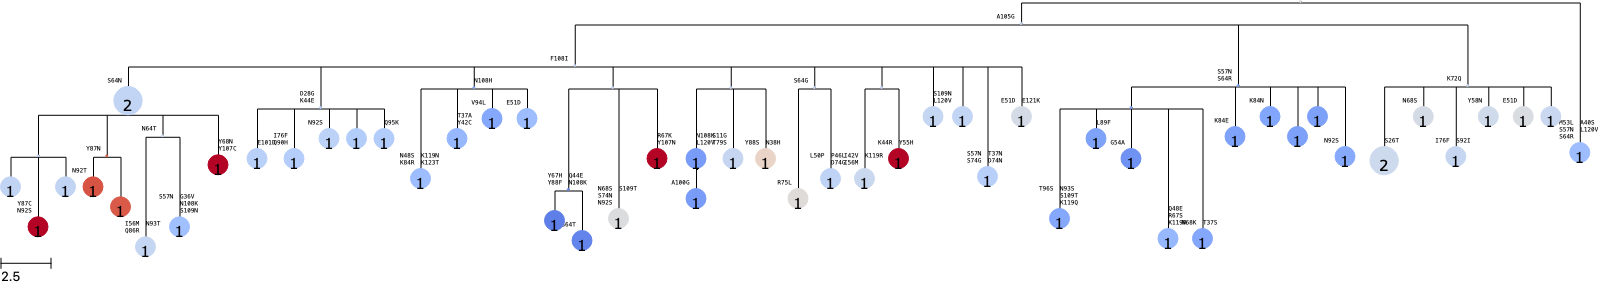

gc81HK


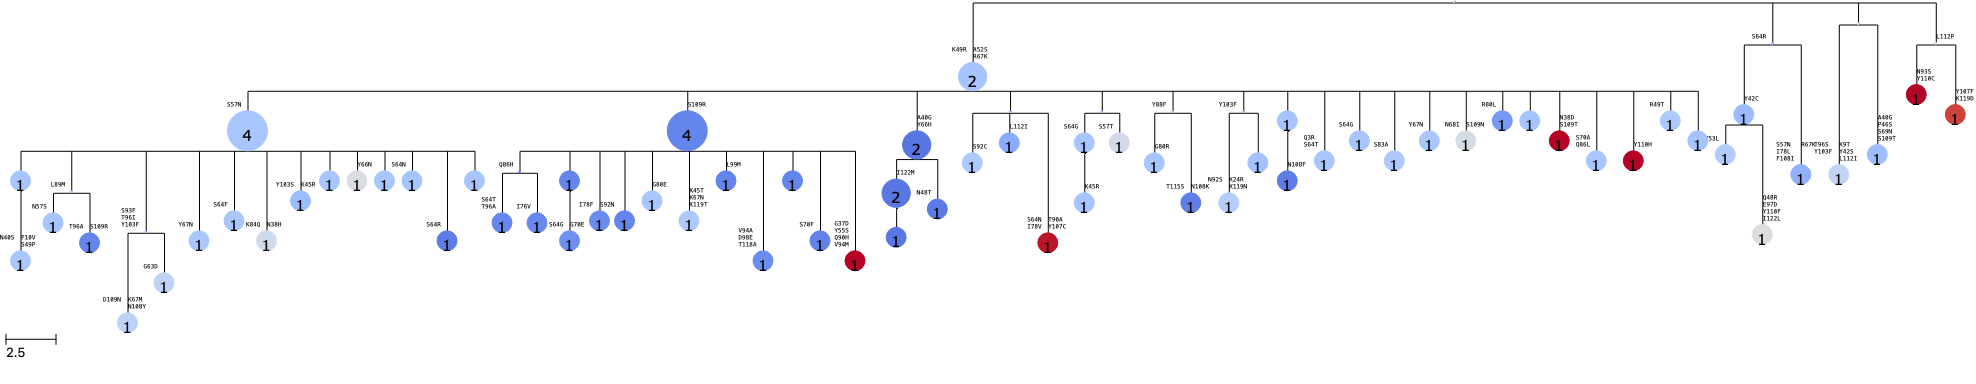

gc1HK


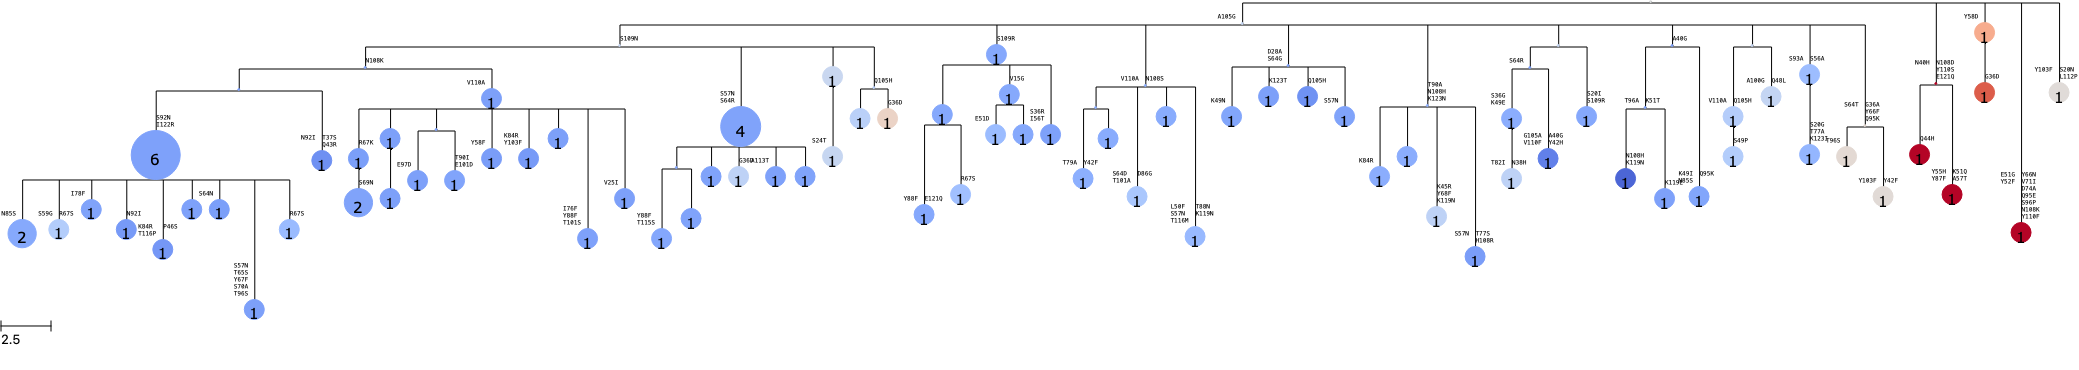

gc68HK


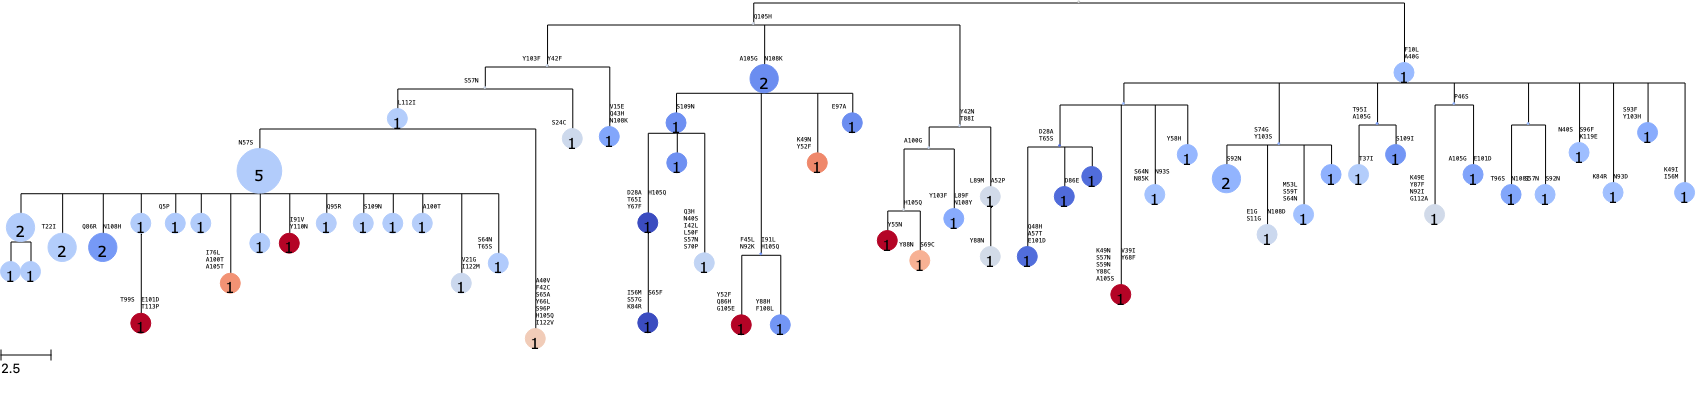

gc79HK


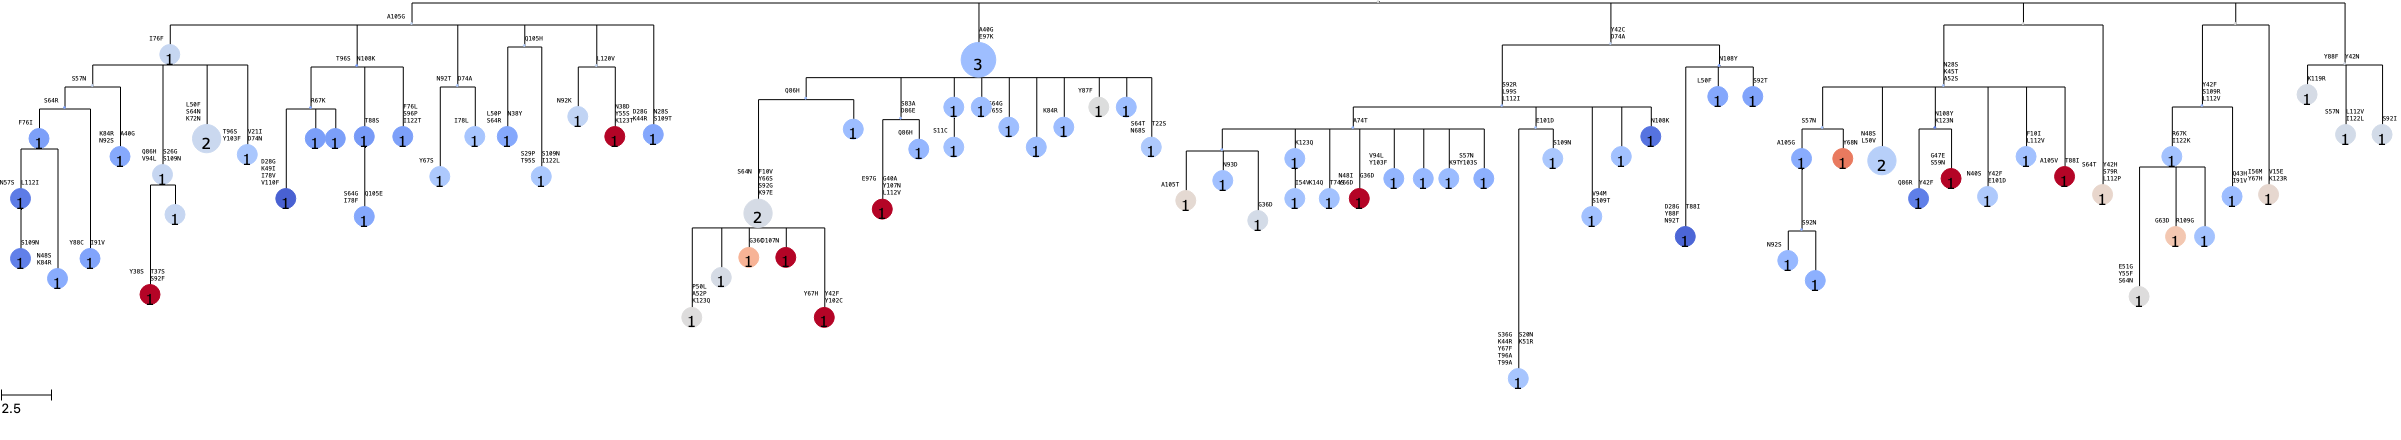

gc80HK


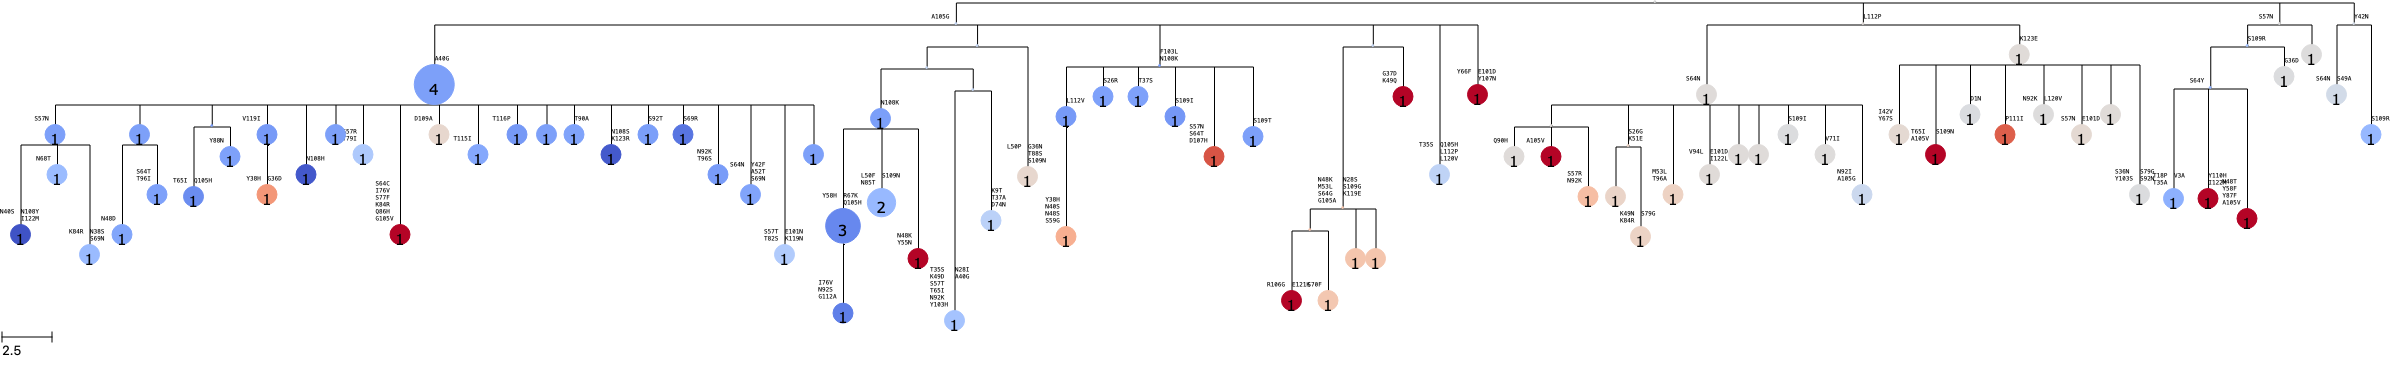

gc69HK


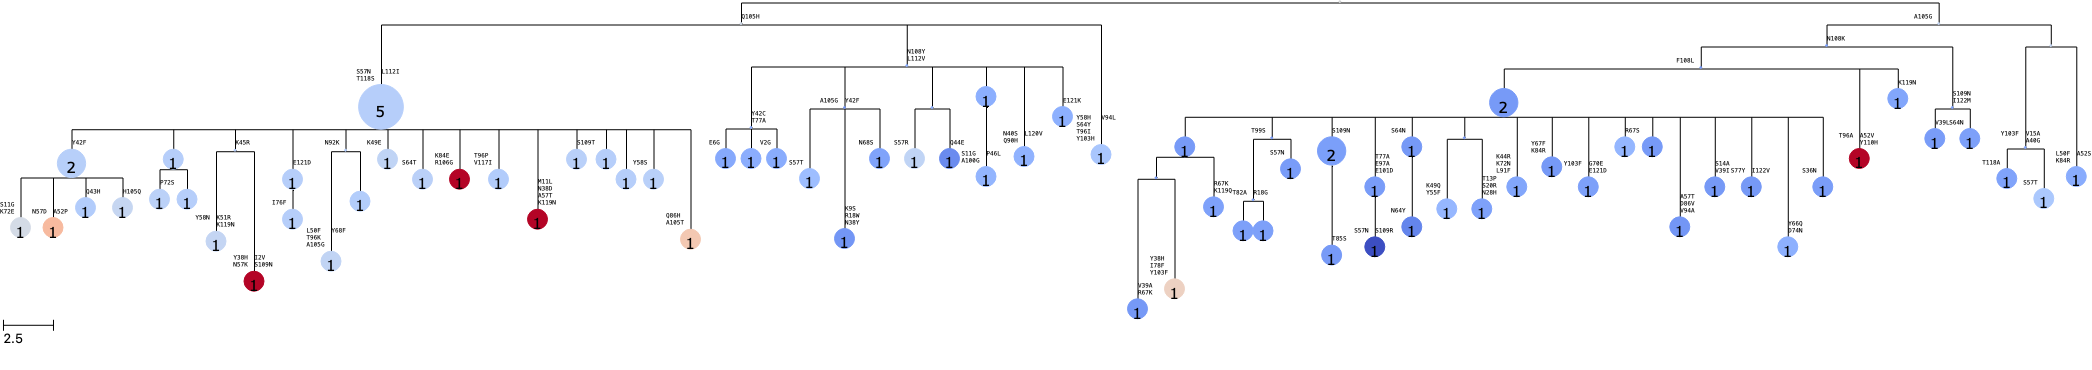

gc70HK


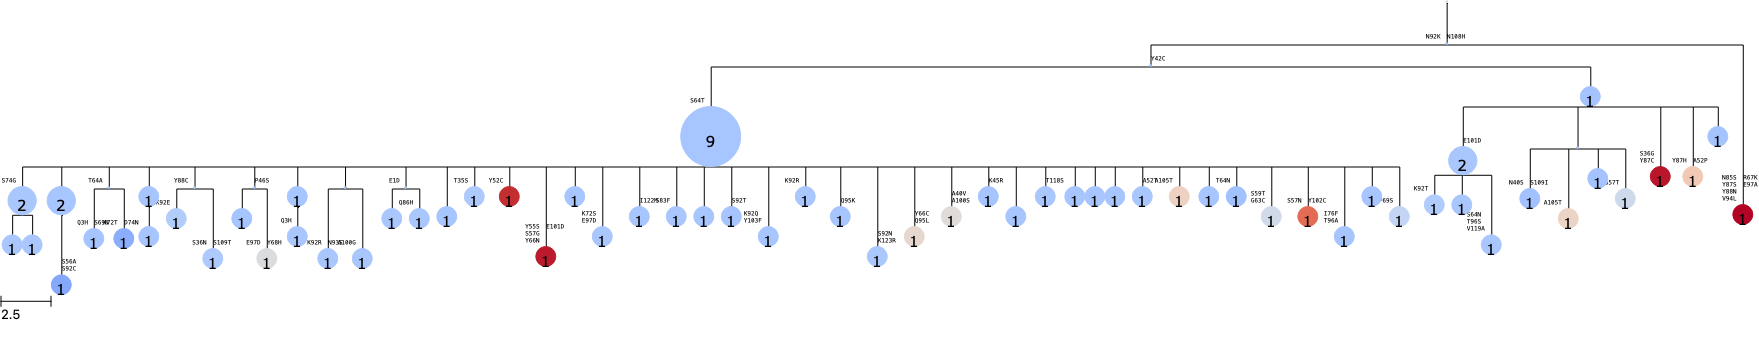

gc15HK


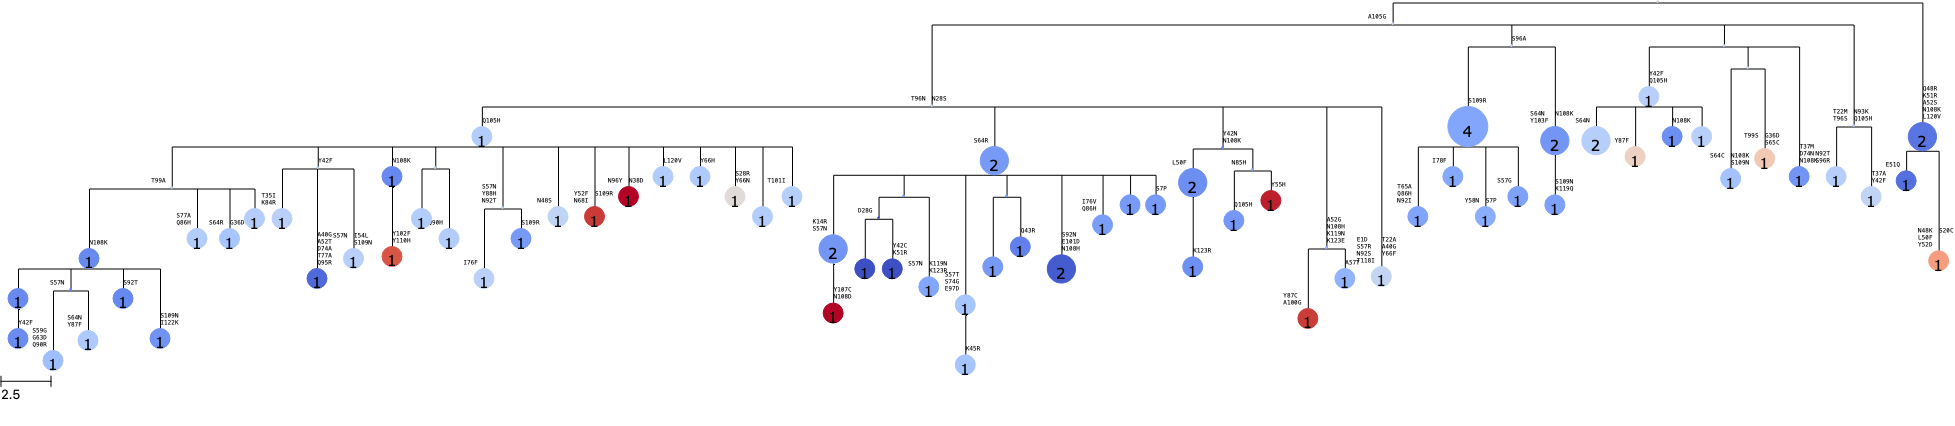

gc32HK


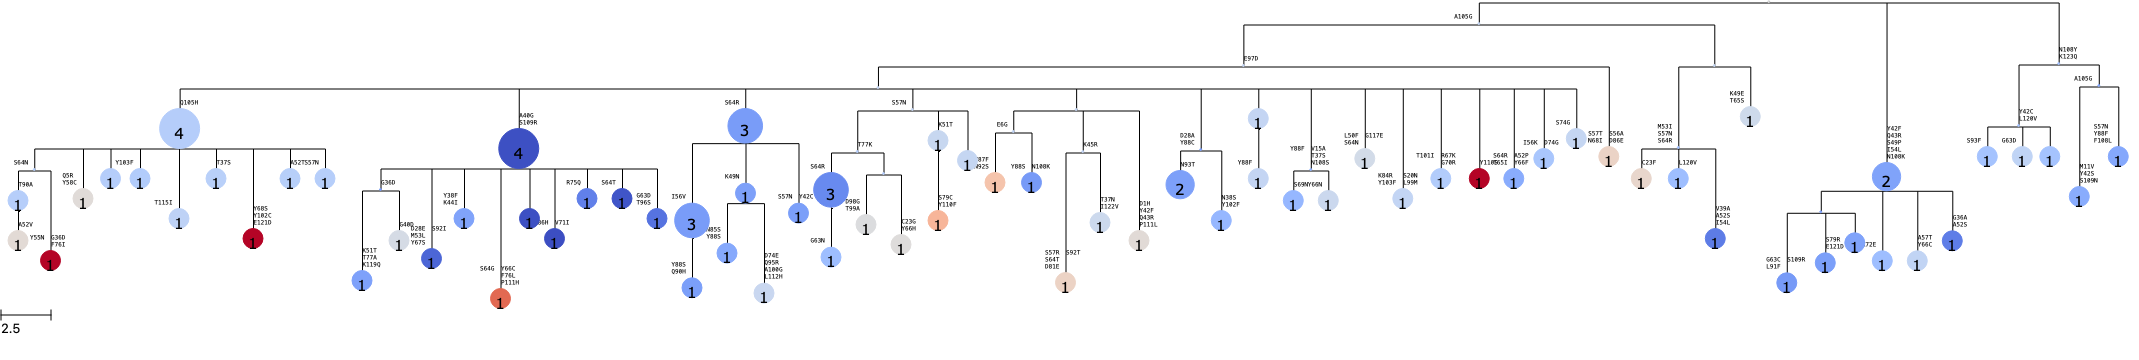

gc20HK-BC1


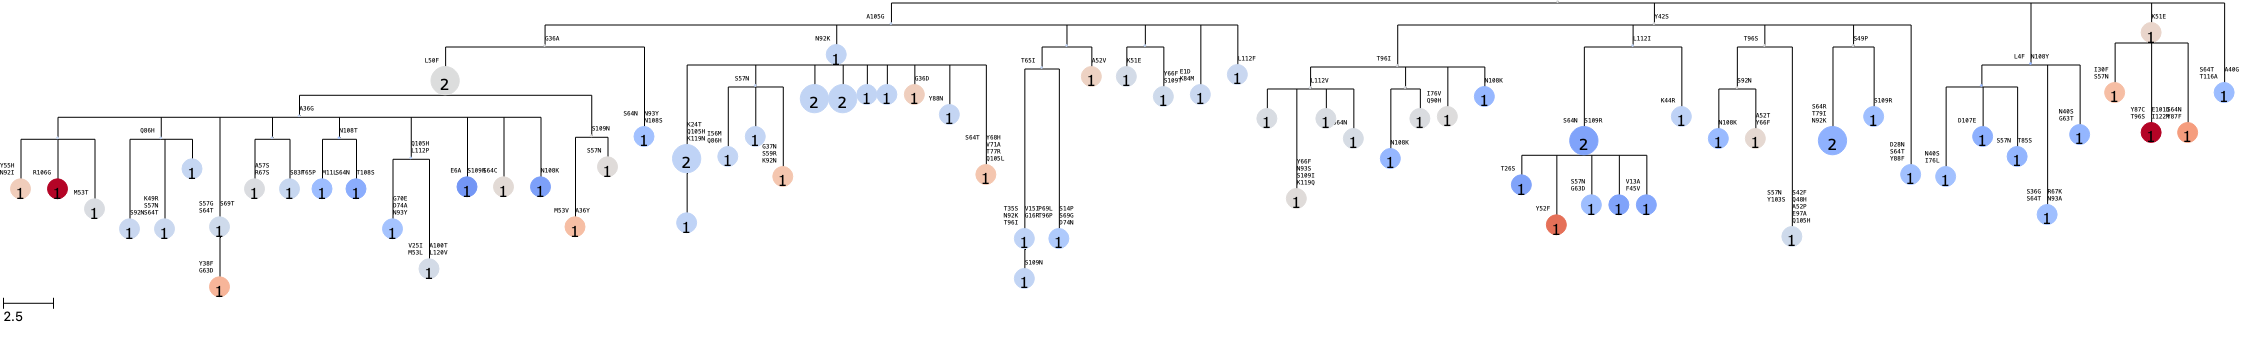

gc38HK-2


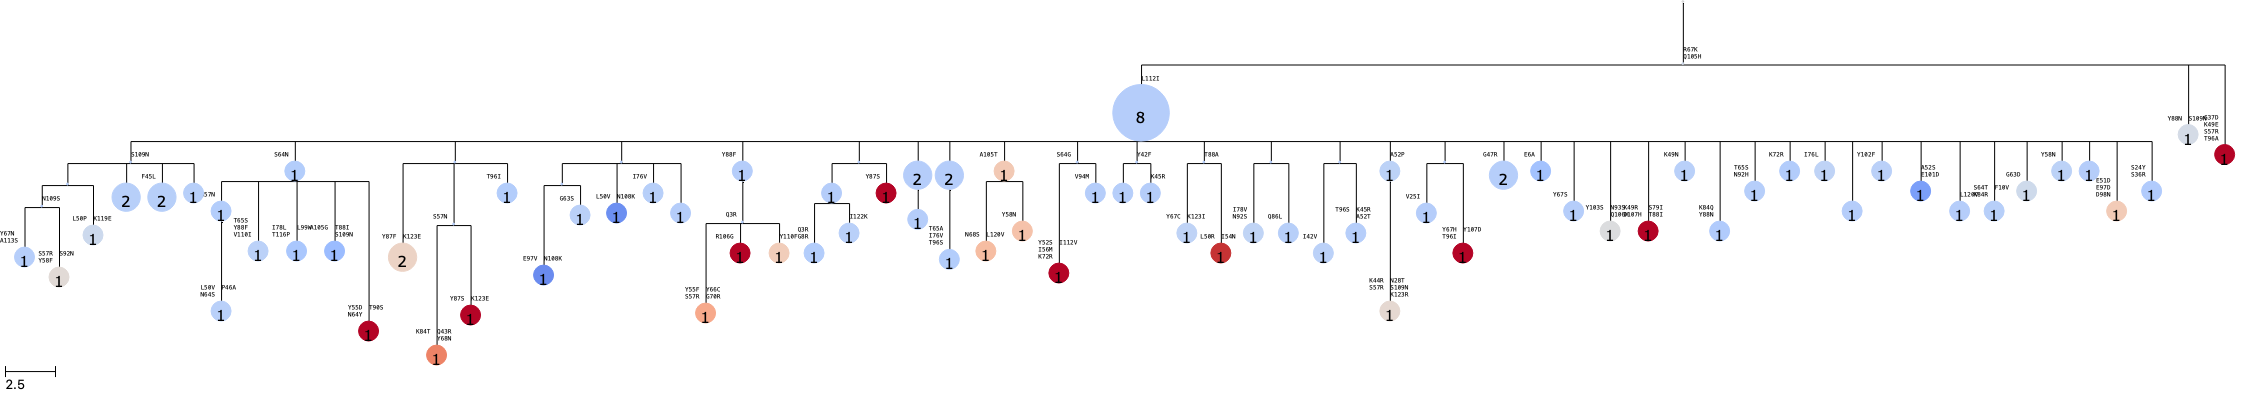

gc72HK-2


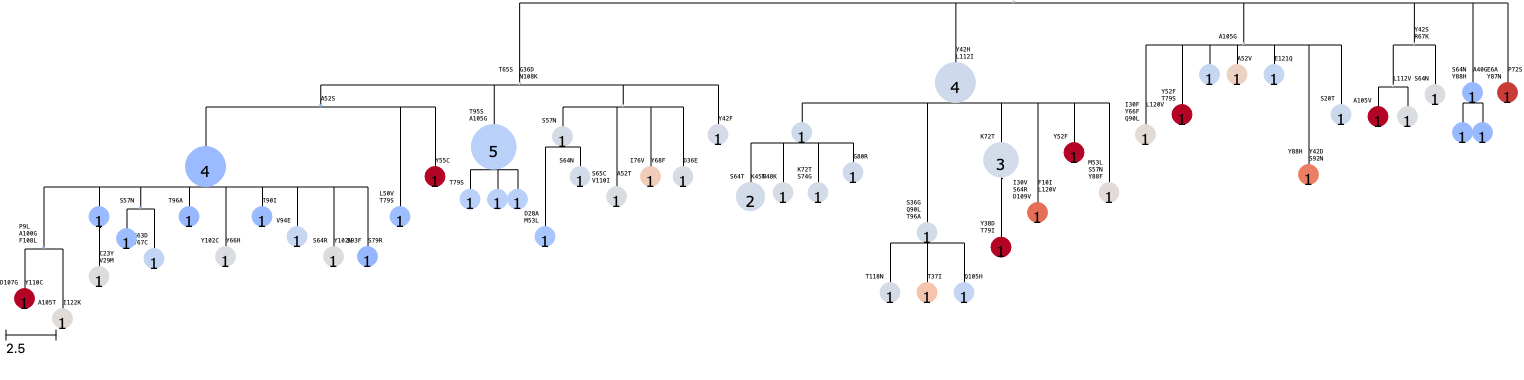

gc73HK-2


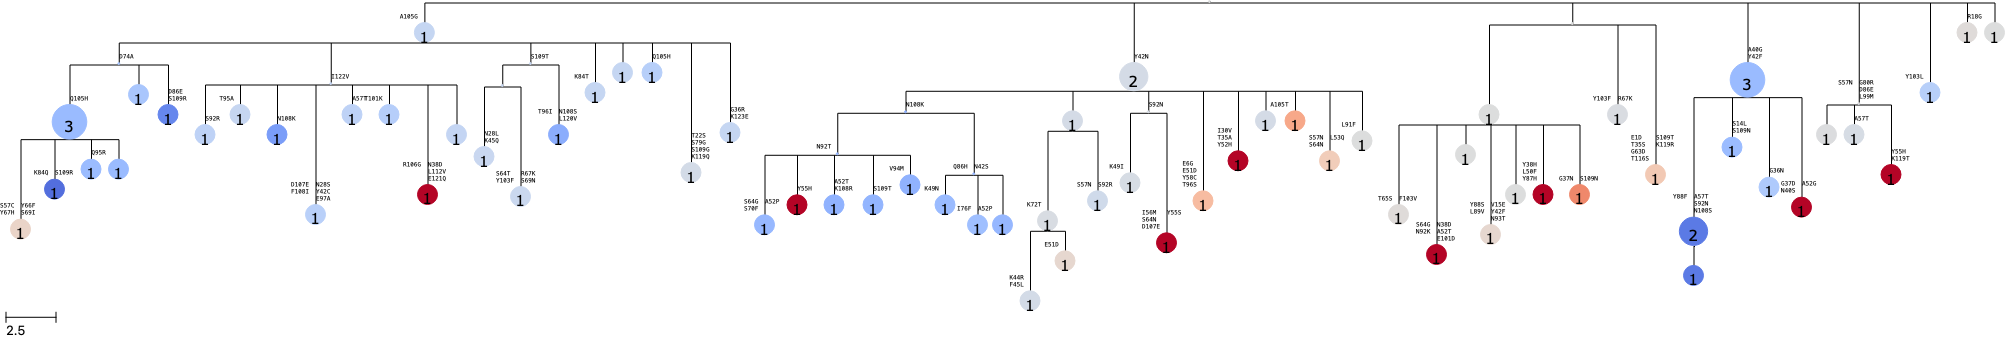

gc58HK-2


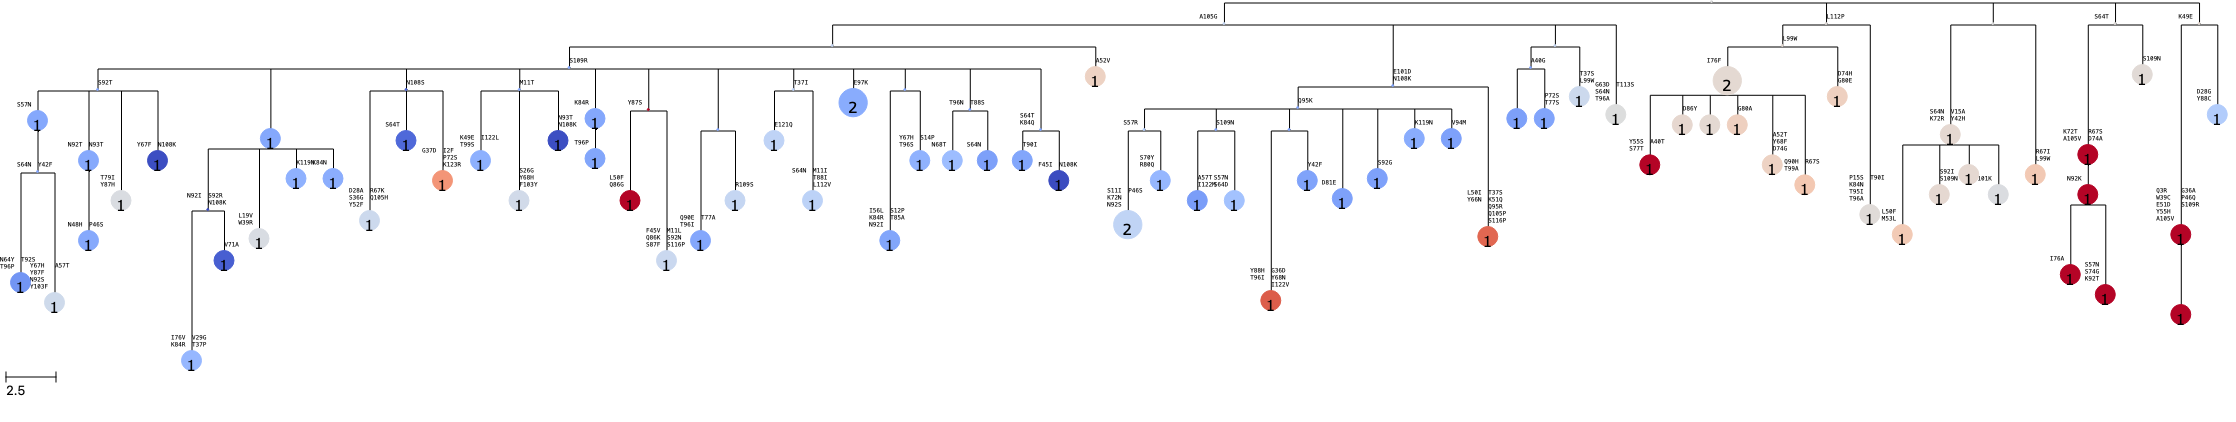

gc74HK-2


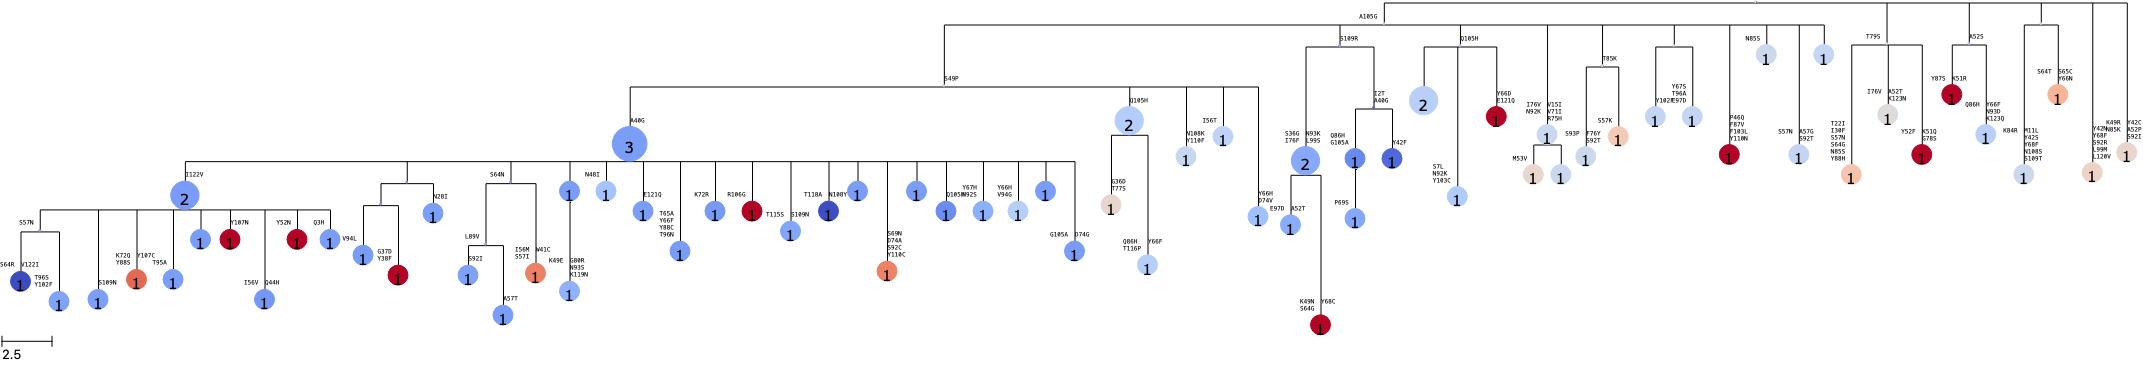

gc48HK-2


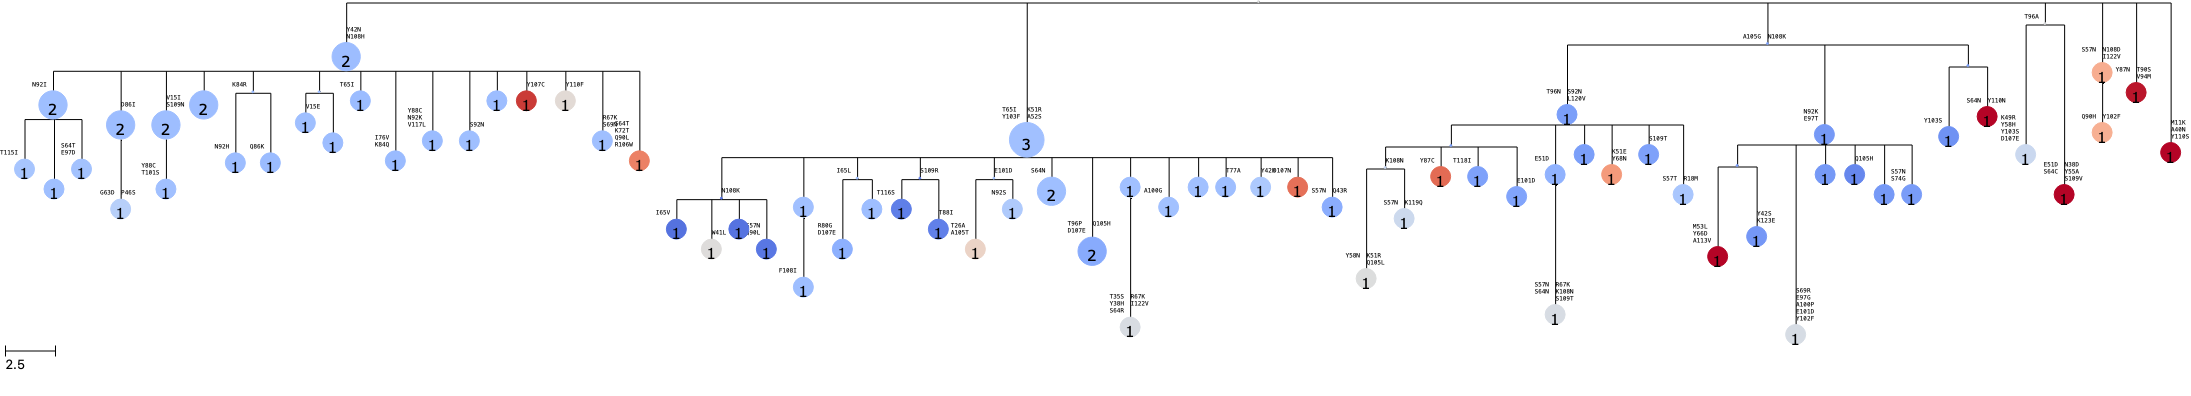

gc47HK-2


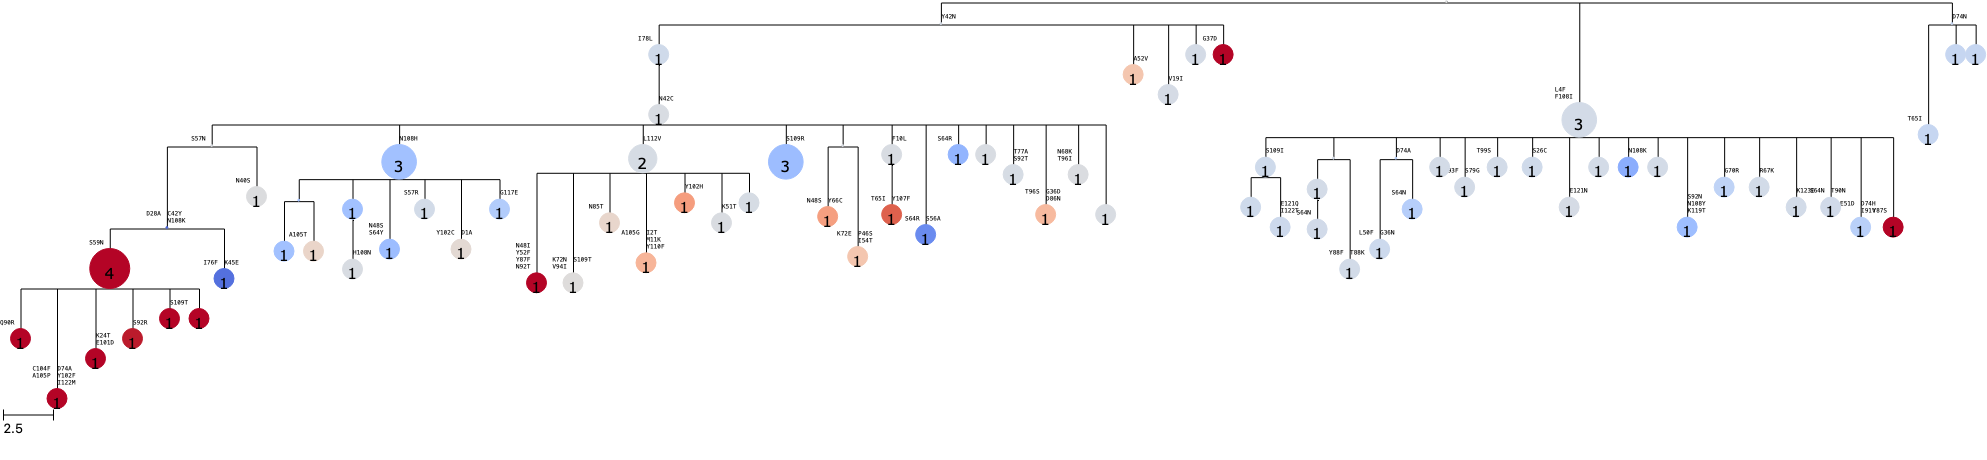

gc78HK-2


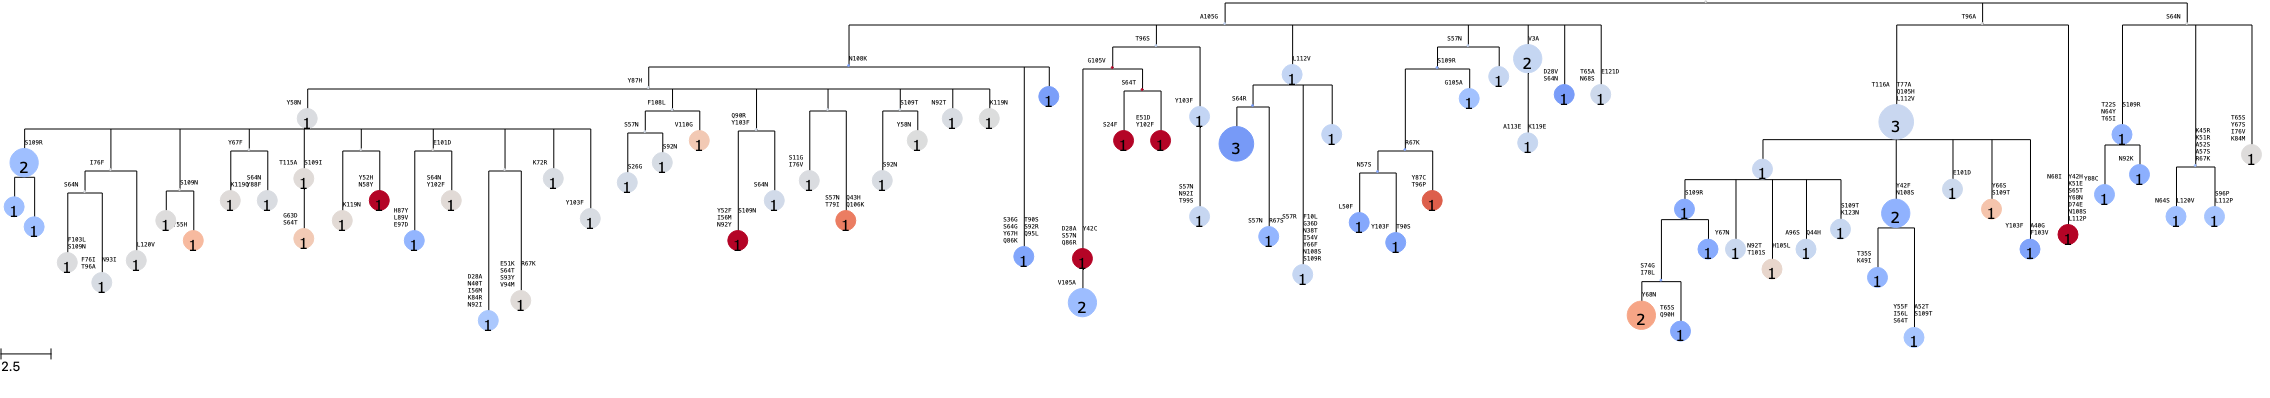

gc55HK-2


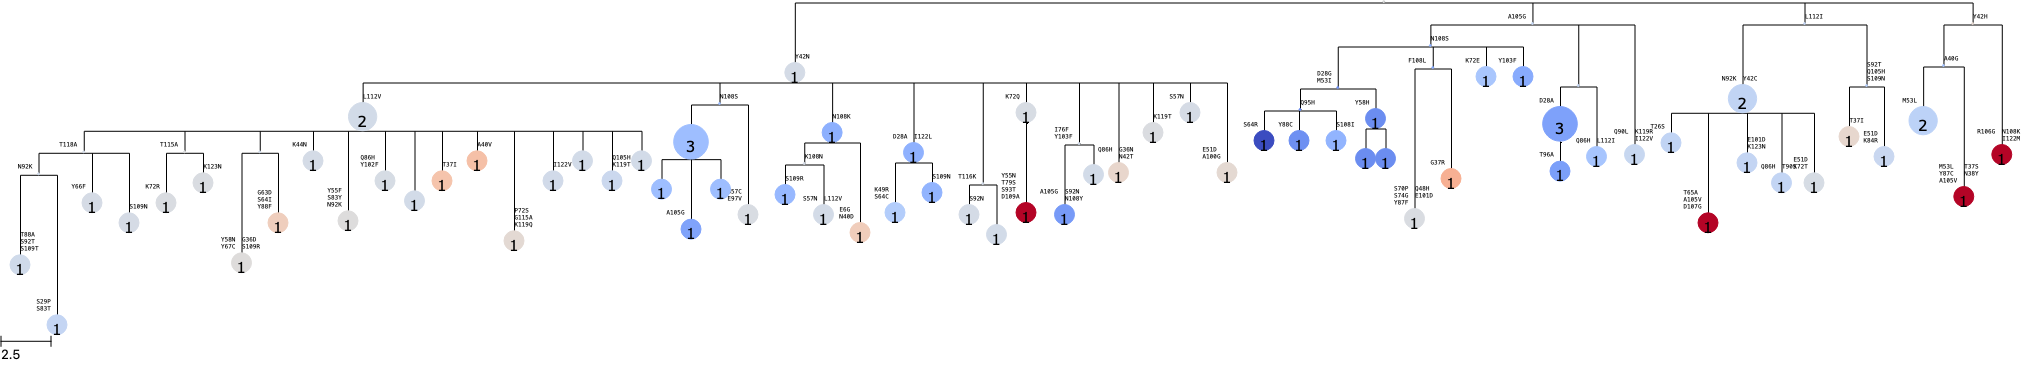

gc82HK-2


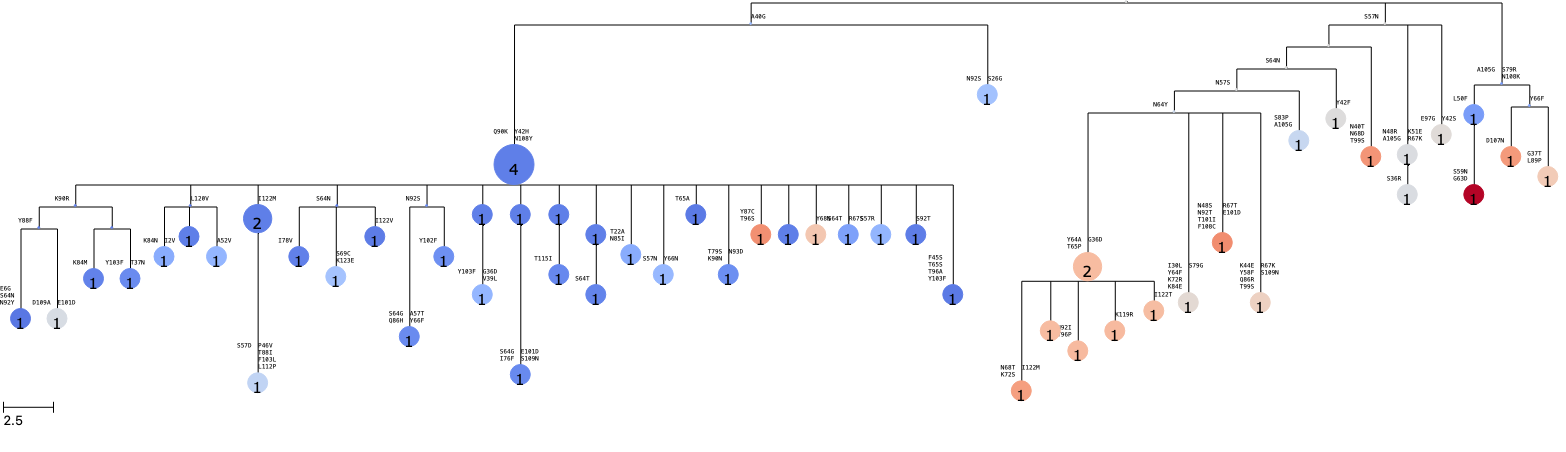

gc83HK-2


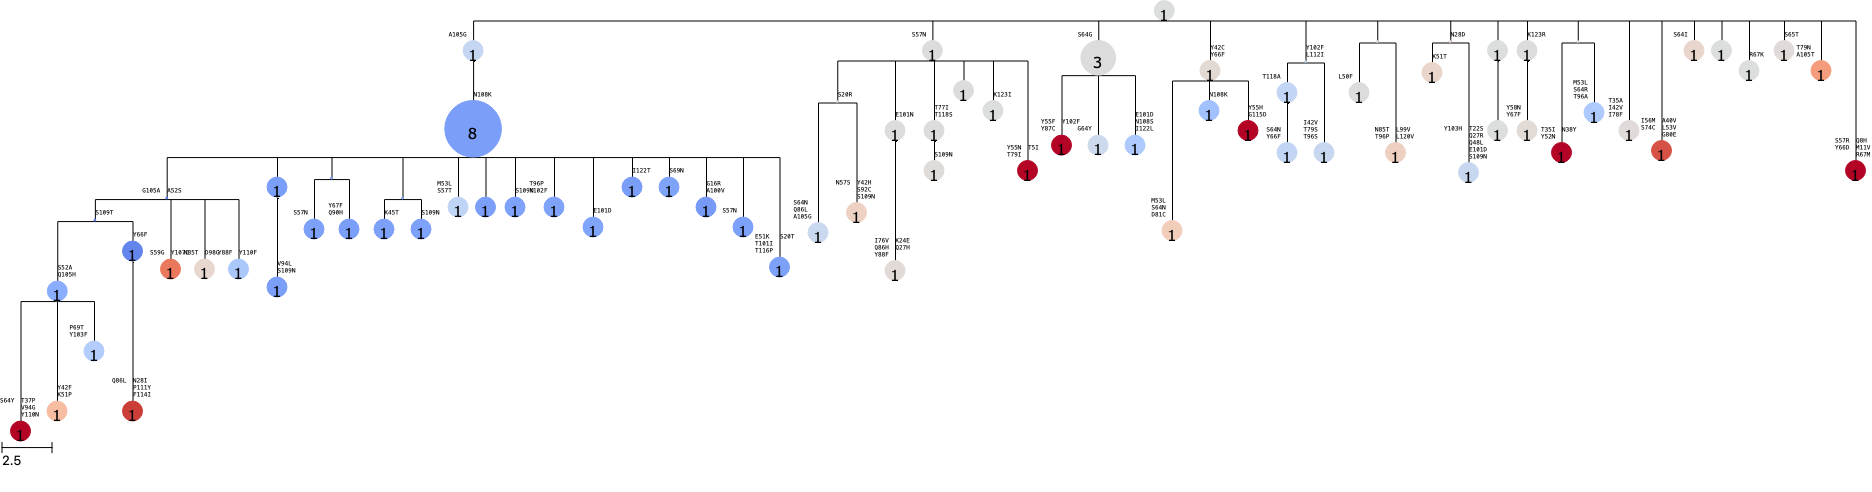

In [11]:
for gc, tree in trees.items():
    print(gc)
    for file in (f"output/plots/colormapped_gctrees/{gc}.delta_bind.svg", "%%inline"):
        rendering = tree.render(file, scale=20,
                            colormap=bind_colormap(tree, vmin, vmax),
                            frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                            position_map=igh_pos_map.site, position_map2=igk_pos_map.site)
    display(rendering)

In [12]:
def local_branching(tree, τ=1, τ0=0.1):
    r"""Add local branching statistics (Neher et al. 2014) as tree node
    features to the ETE tree attribute of a ``gctree.CollapsedTree`` object.
    
    Args:
        τ: decay timescale
        τ0: effective branch length for branches with zero mutations
    """
    # the fixed integral contribution for clonal cells indicated by abundance annotations
    clone_contribution = τ * (1 - np.exp(-τ0 / τ))

    # post-order traversal to populate downward integral for each node
    for node in tree.tree.traverse(strategy="postorder"):
        if node.is_leaf():
            node.add_feature("LB_down", node.abundance * clone_contribution
                                        if node.abundance > 1 else 0
                            )
        else:
            node.add_feature("LB_down",
                             node.abundance * clone_contribution
                             + sum(τ * (1 - np.exp(-child.dist / τ))
                                   + np.exp(-child.dist / τ) * child.LB_down
                                   for child in node.children)
                            )

    # pre-order traversal to populate upward integral for each node
    for node in tree.tree.traverse(strategy="preorder"):
        if node.is_root():
            node.add_feature("LB_up", 0)
        else:
            node.add_feature("LB_up",
                             τ * (1 - np.exp(-node.dist / τ))
                             + np.exp(-node.dist / τ) * (node.up.LB_up + node.up.LB_down)
                            )

    # finally, compute LBI (LBR) as the sum (ratio) of upward and downward integrals at each node
    for node in tree.tree.traverse():
        node.add_feature("LBI", node.LB_down + node.LB_up)
        node.add_feature("LBR", node.LB_down / node.LB_up if not node.is_root() else np.nan)

gc31HK


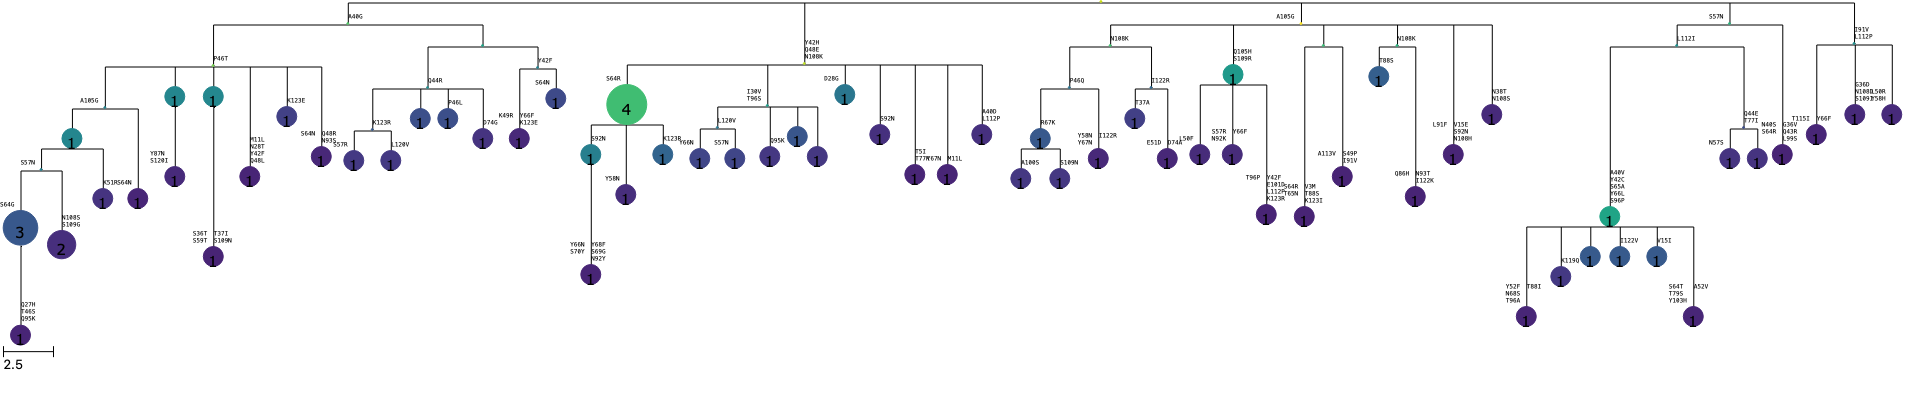

gc50HK


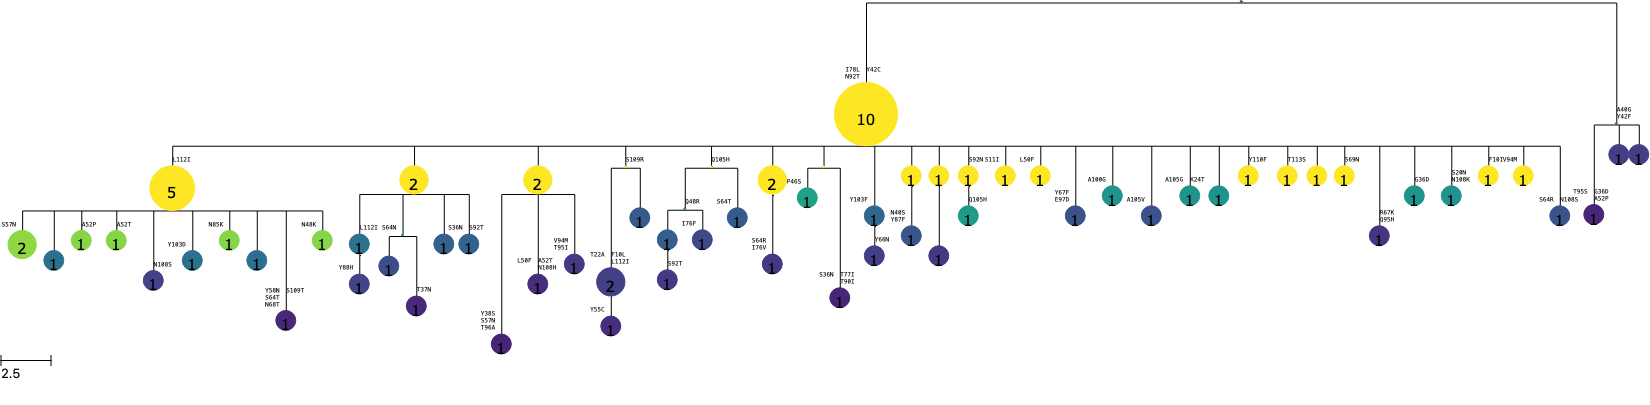

gc59HK


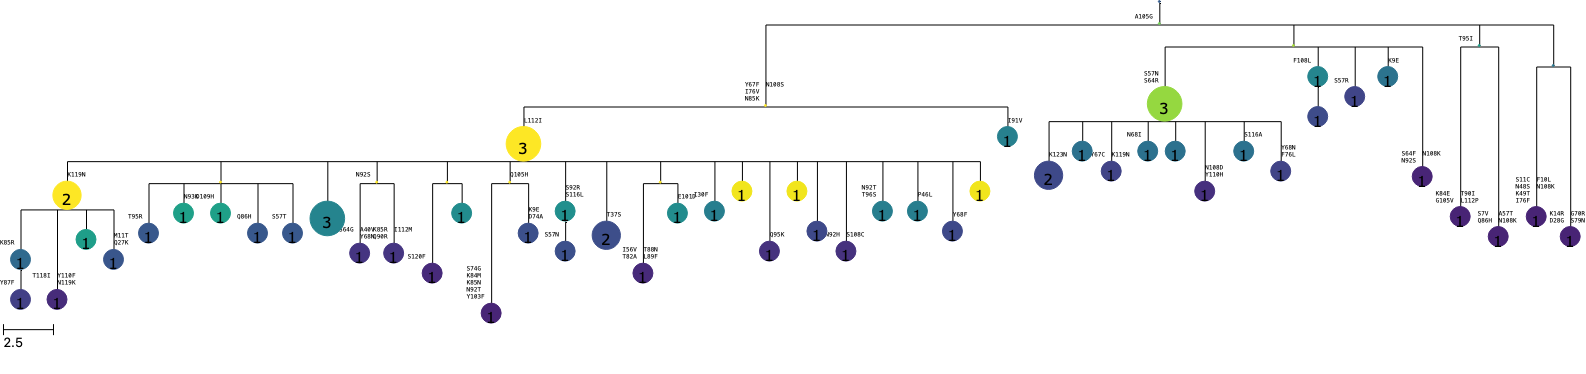

gc17HK


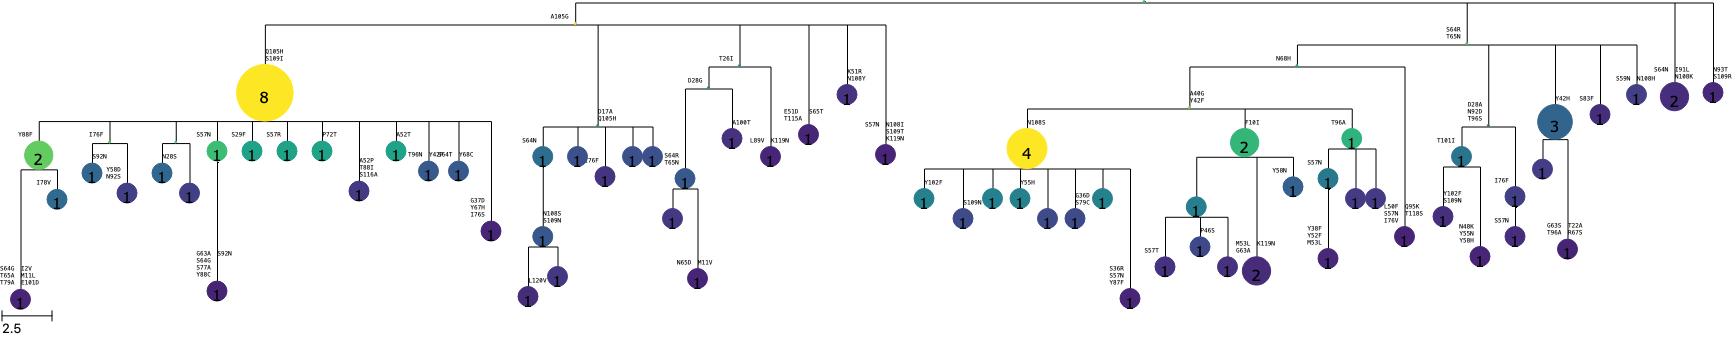

gc56HK


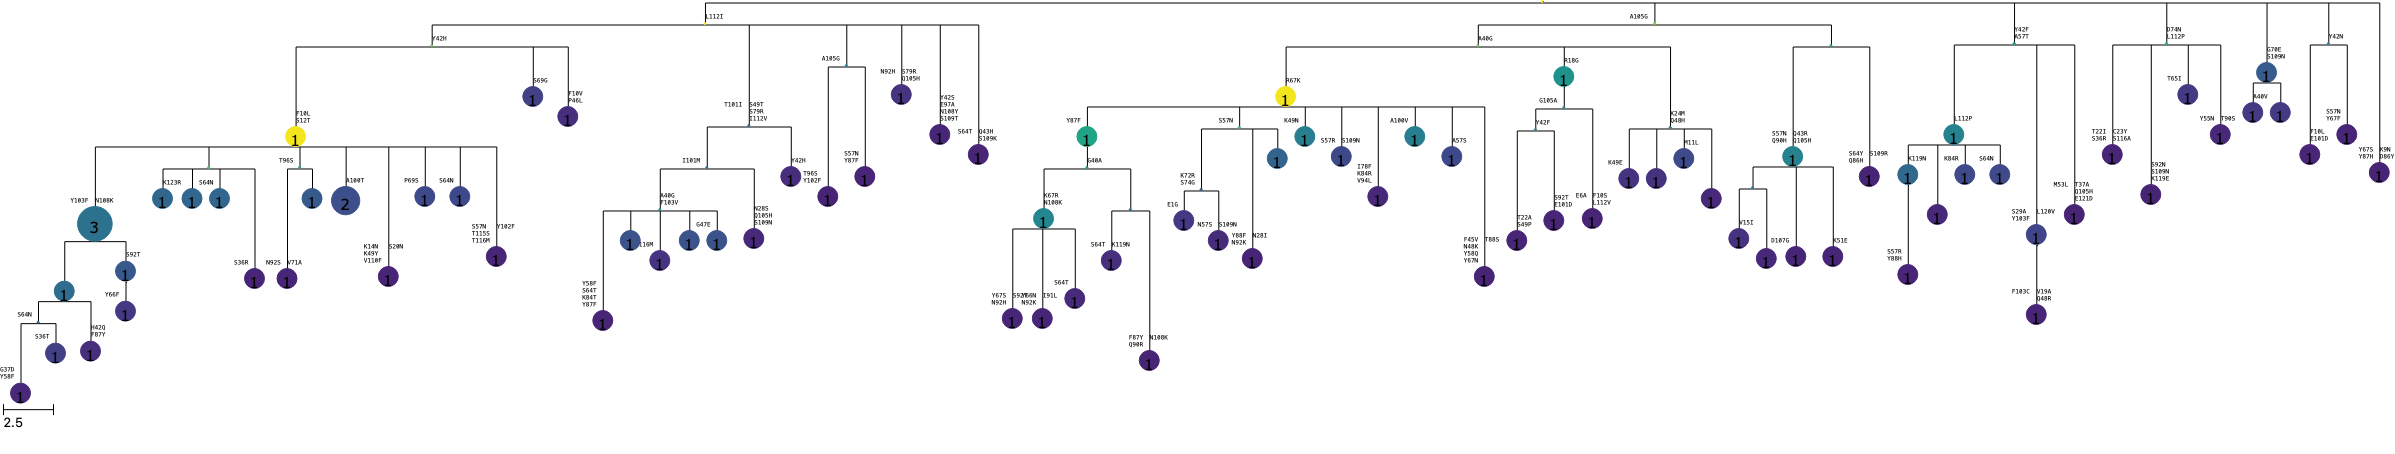

gc39HK


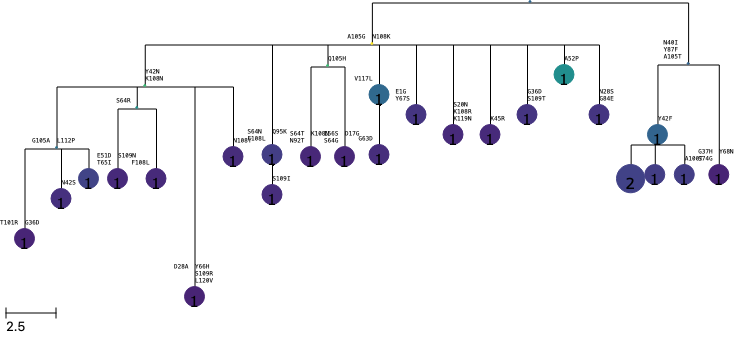

gc77HK


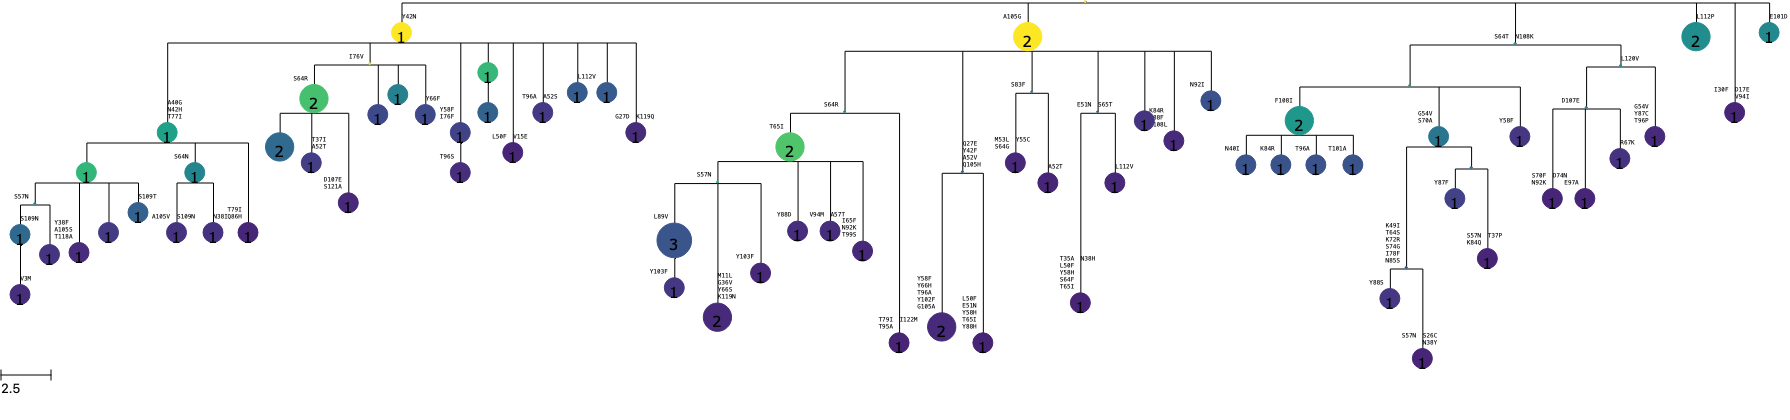

gc16HK


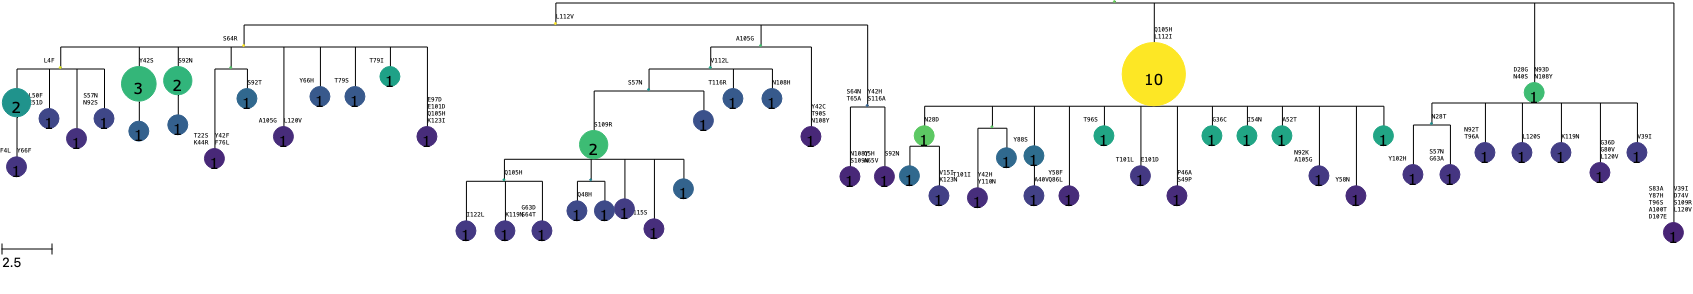

gc46HK


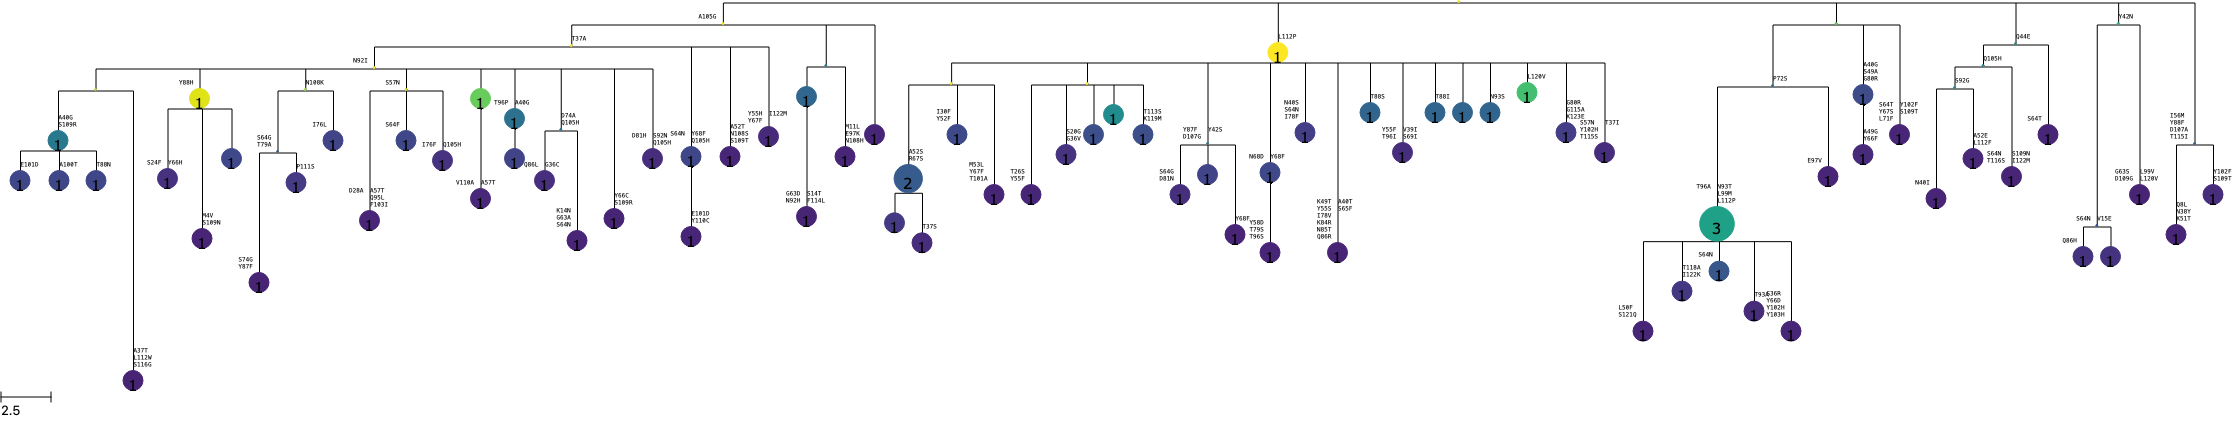

gc30HK


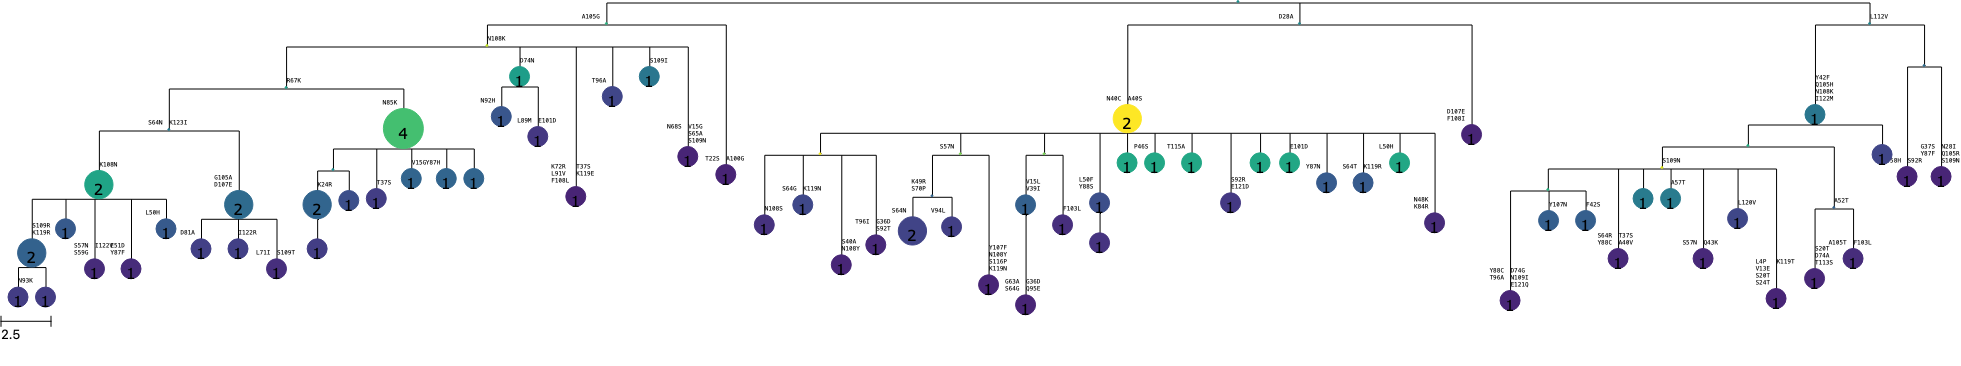

gc14HK


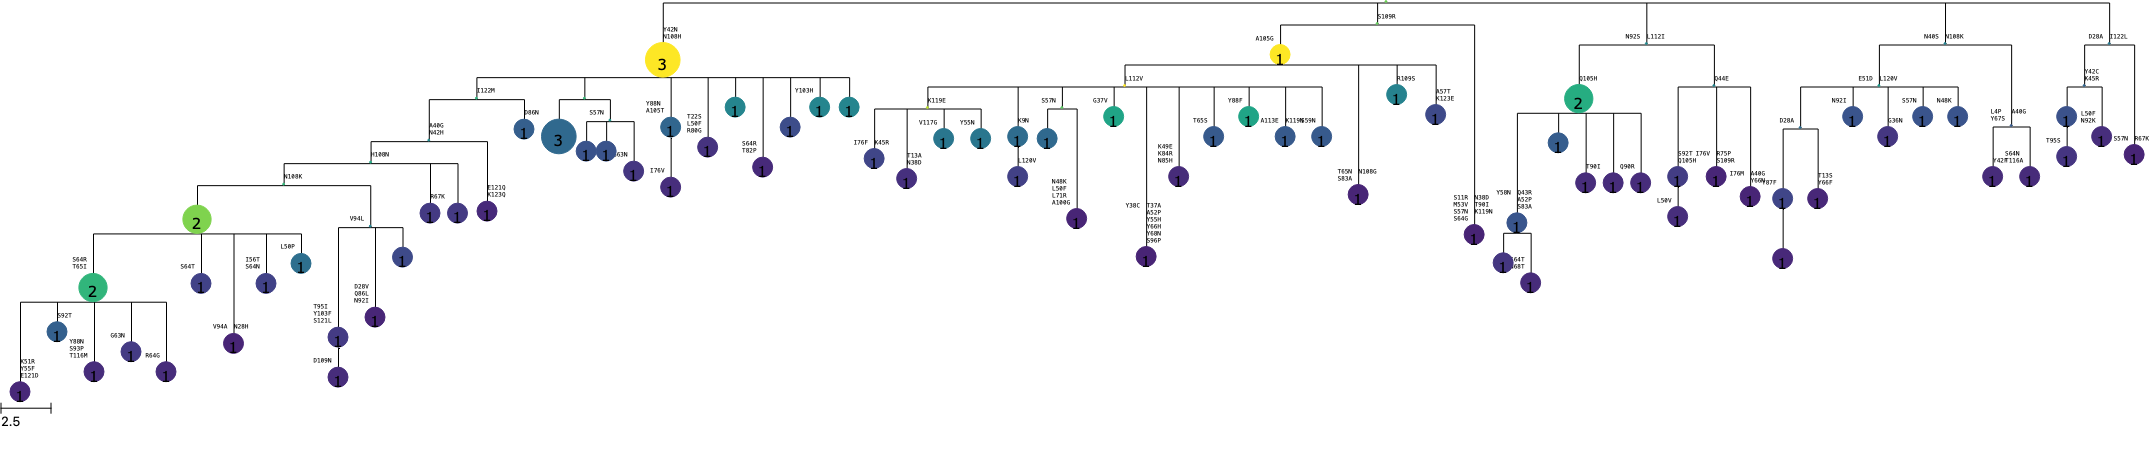

gc6HK


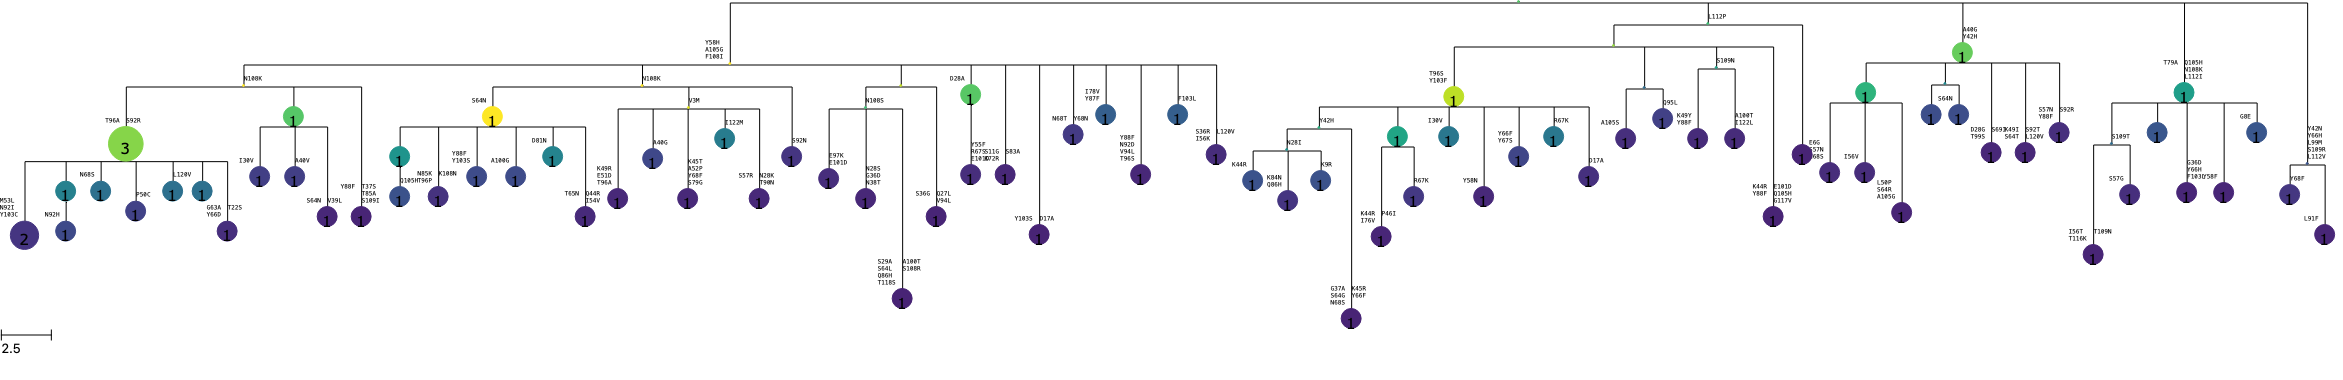

gc2HK


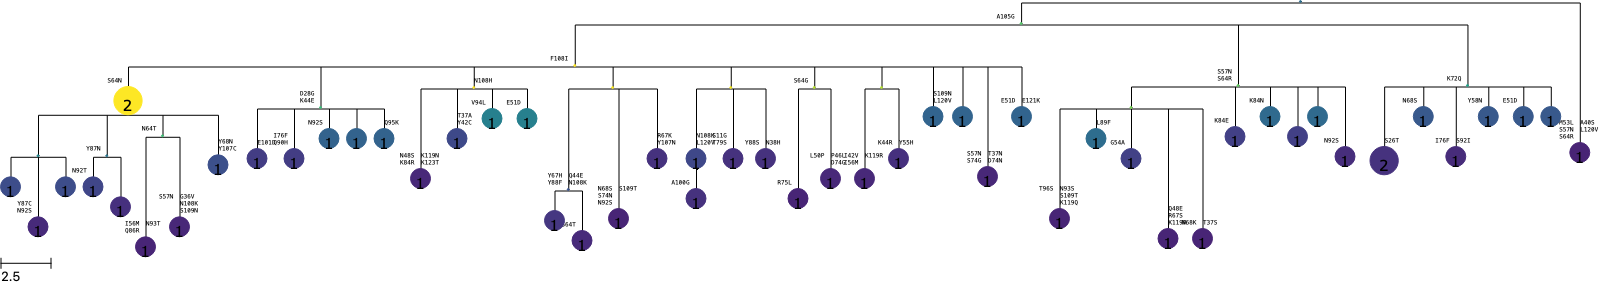

gc81HK


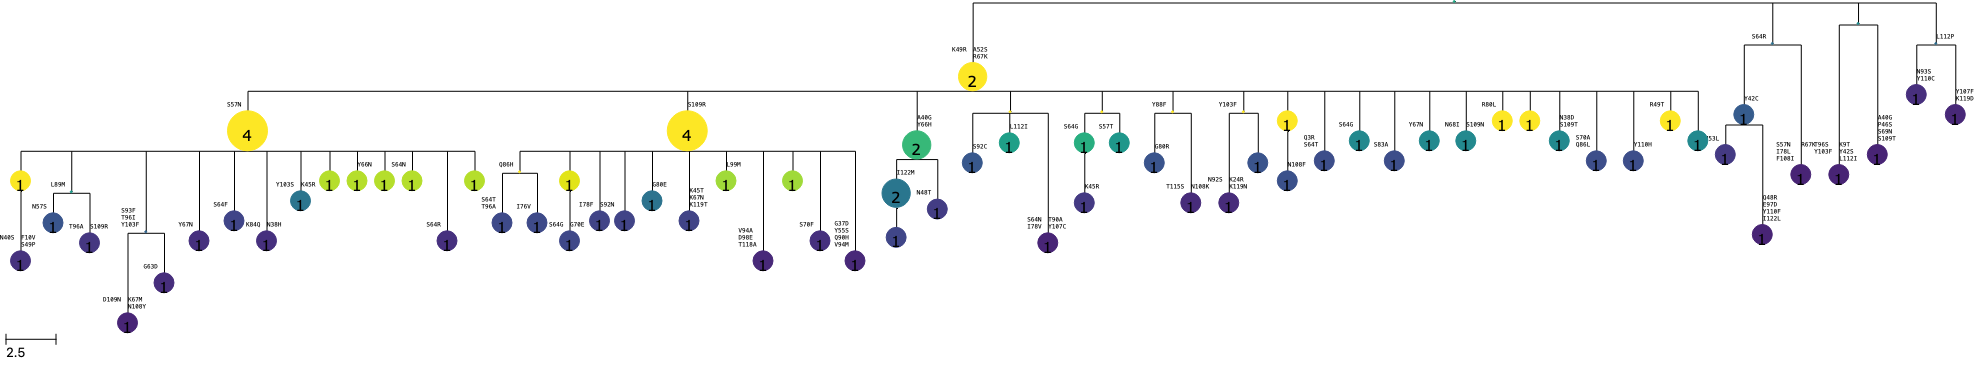

gc1HK


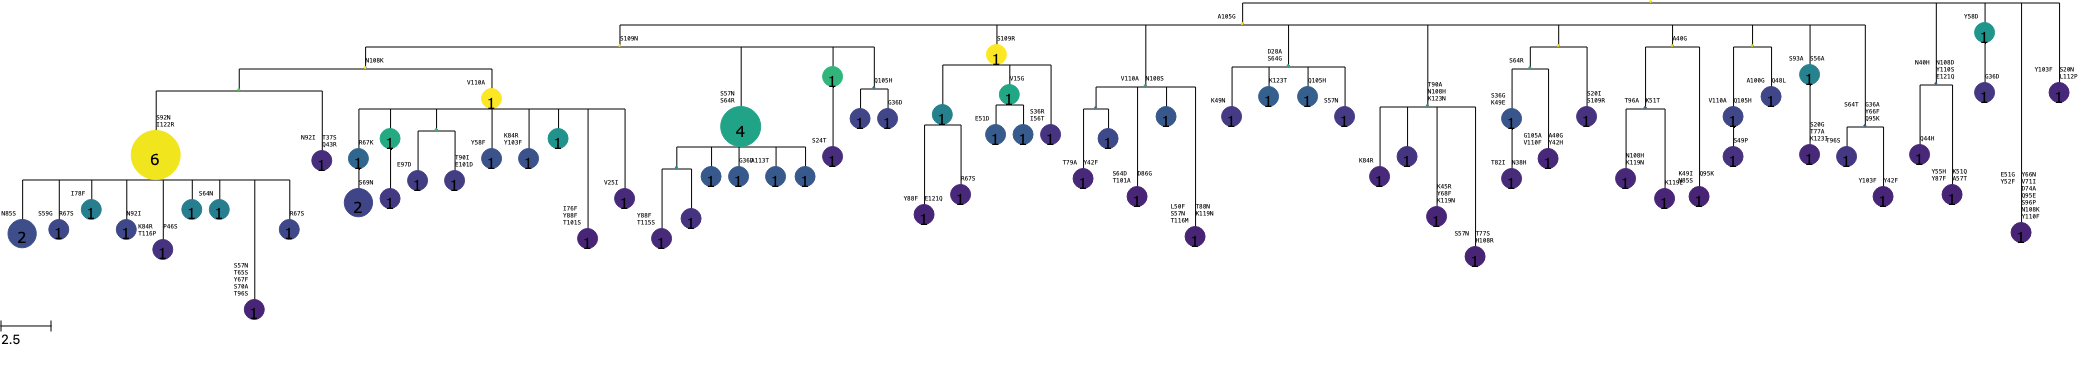

gc68HK


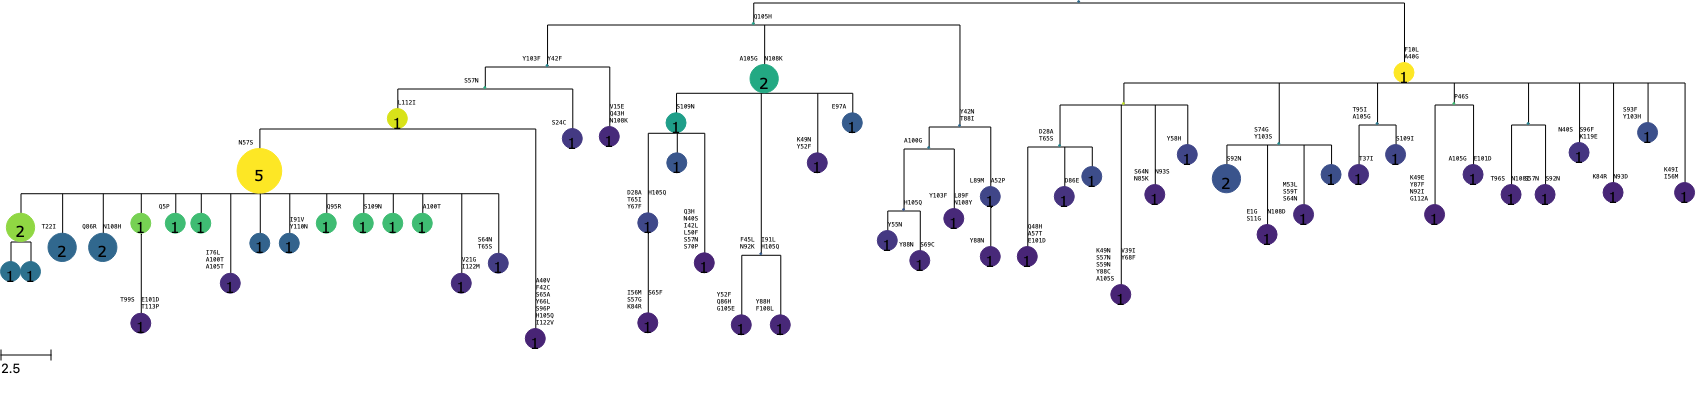

gc79HK


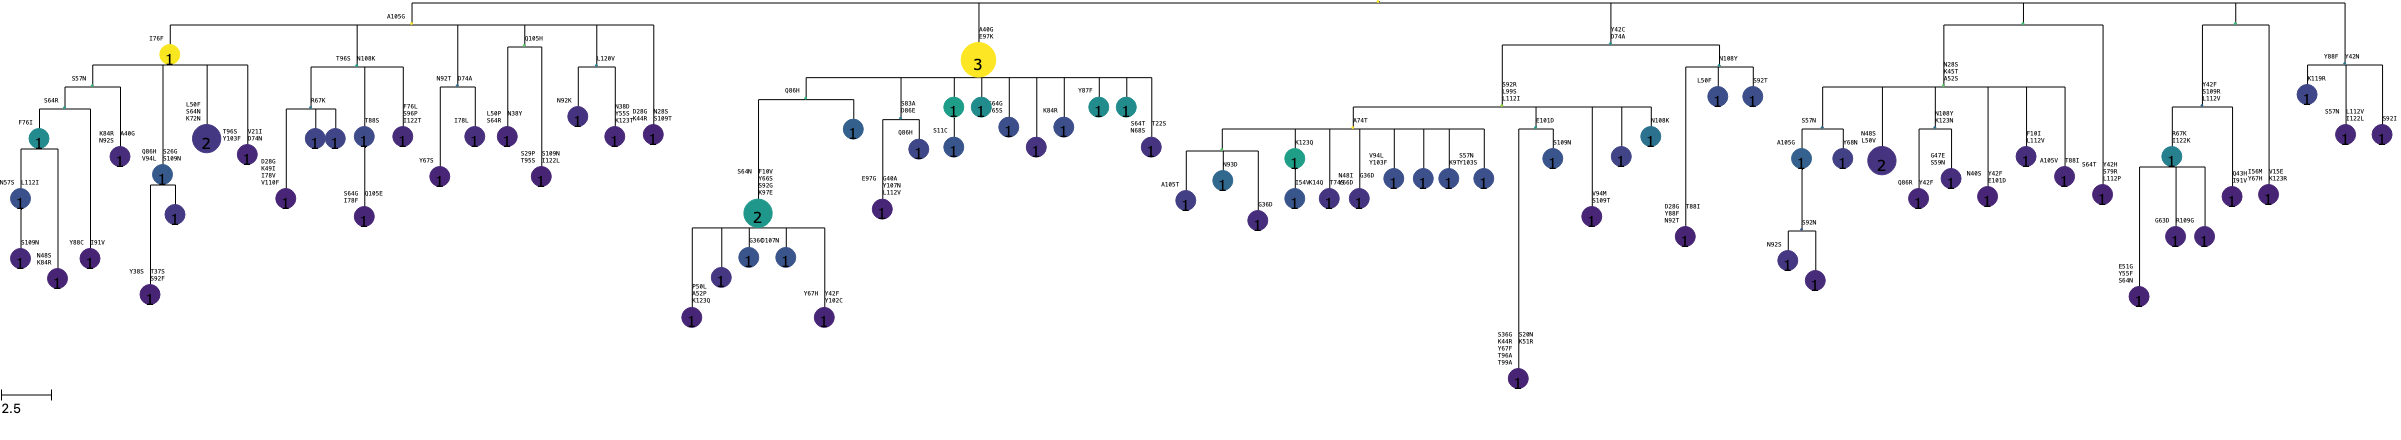

gc80HK


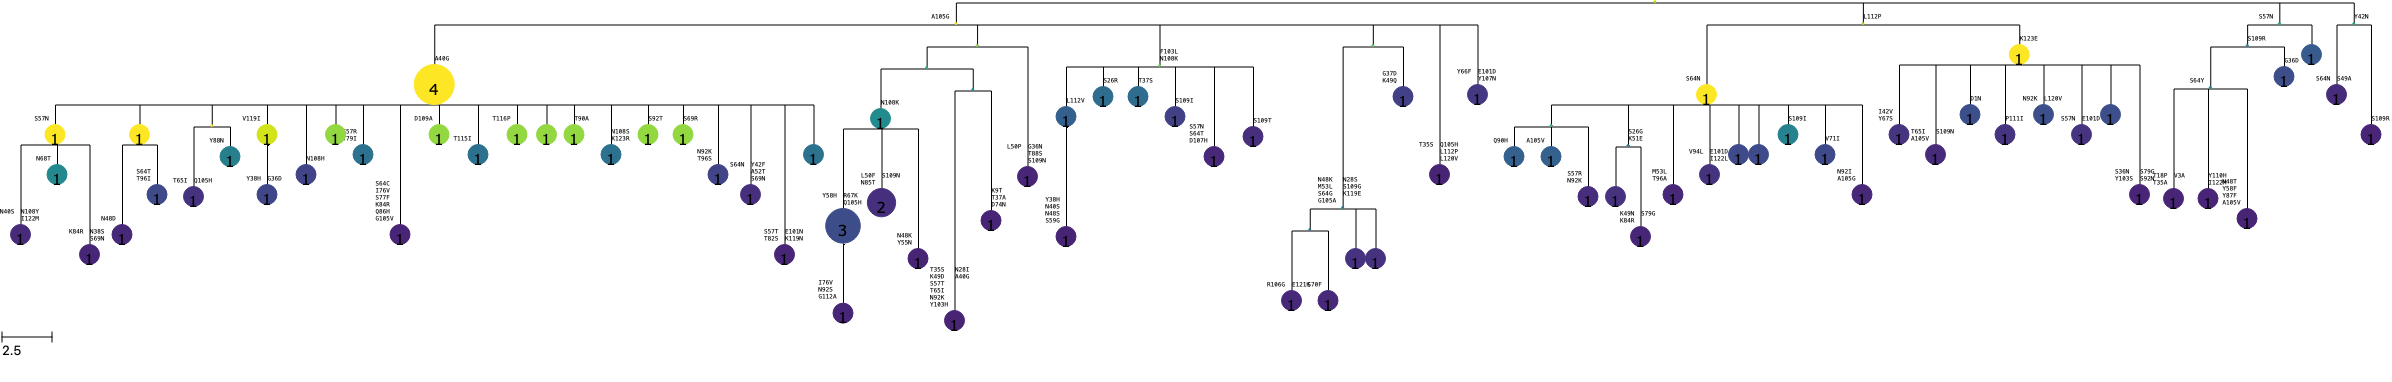

gc69HK


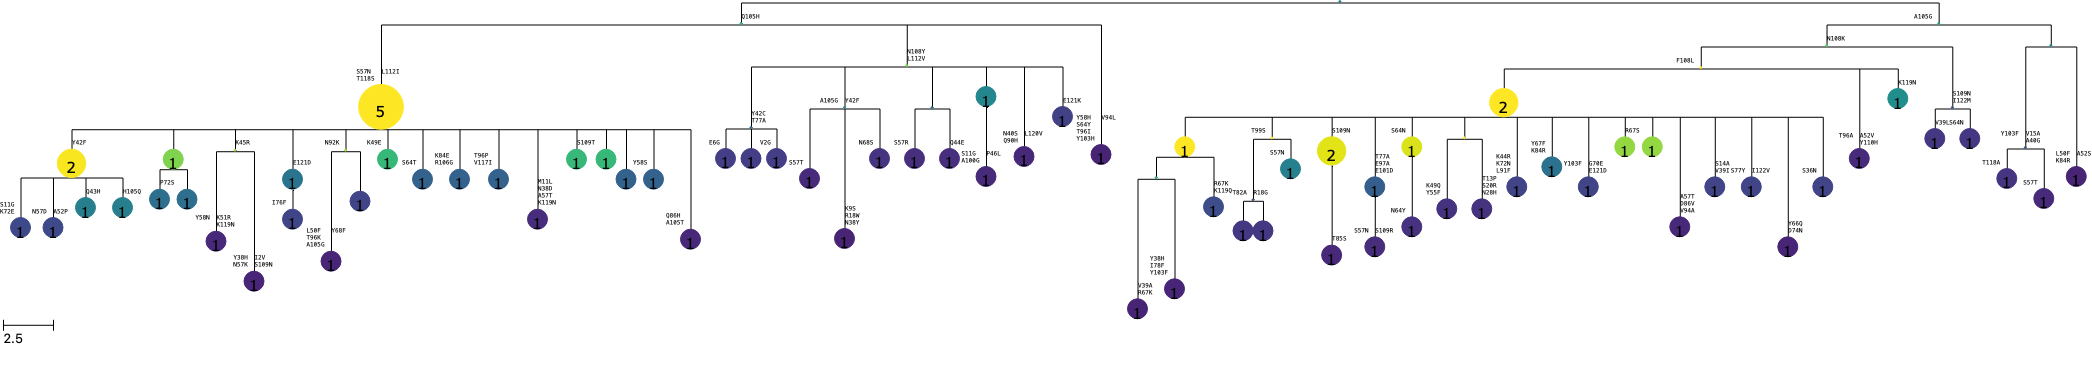

gc70HK


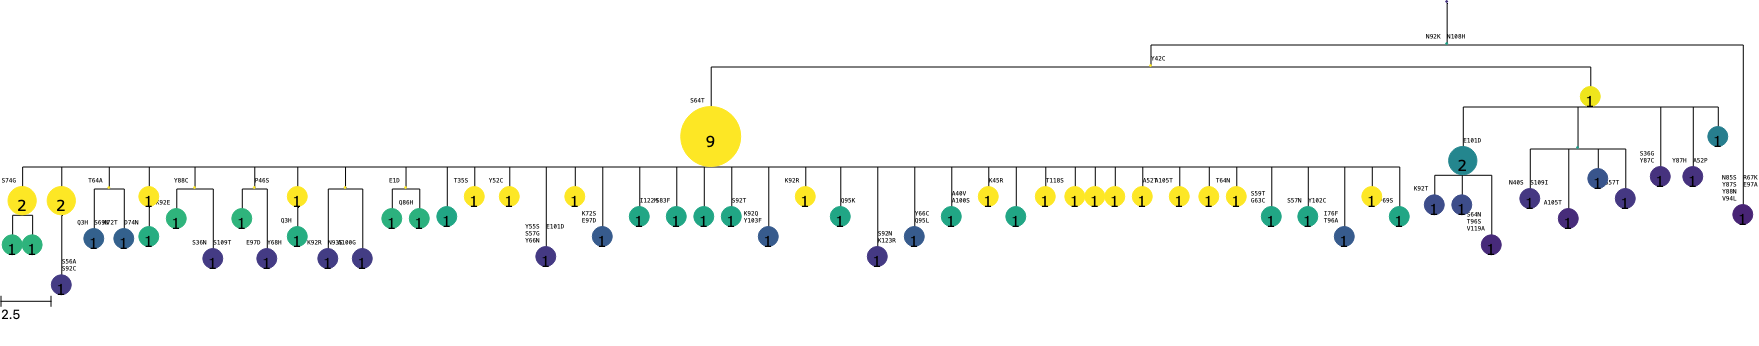

gc15HK


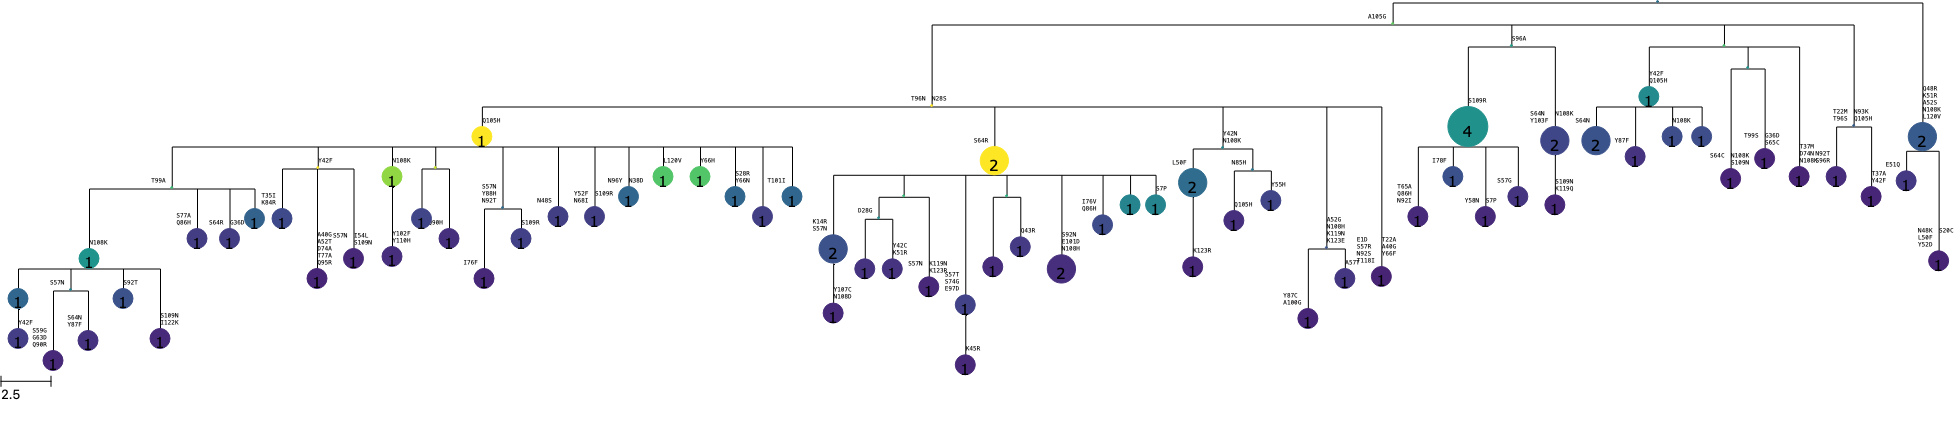

gc32HK


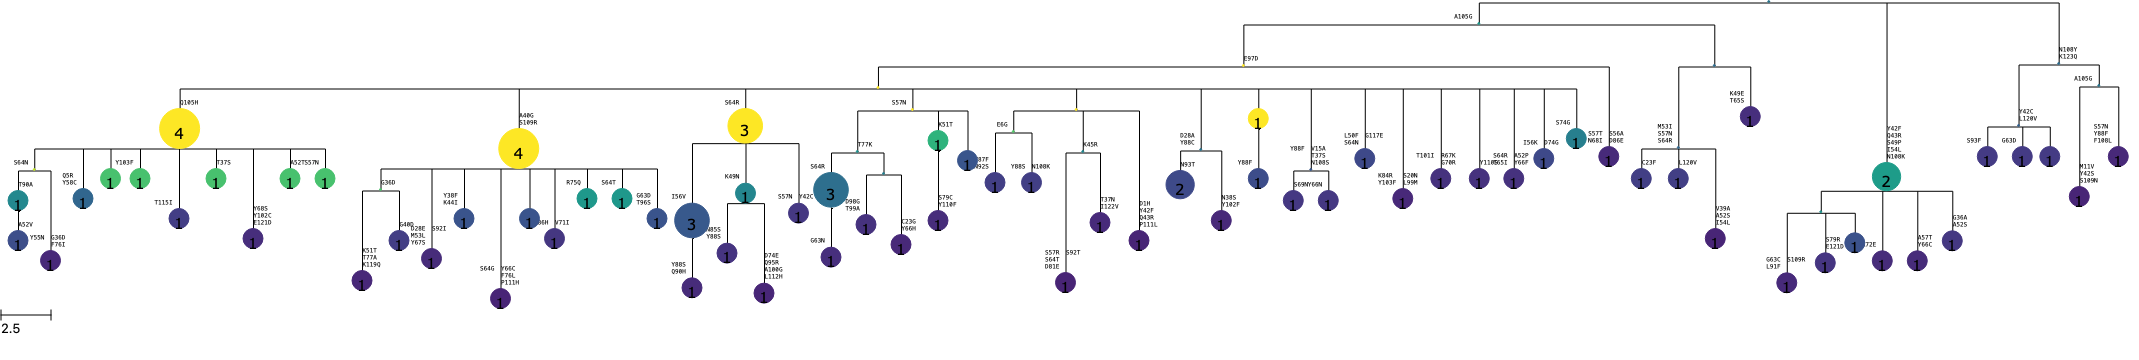

gc20HK-BC1


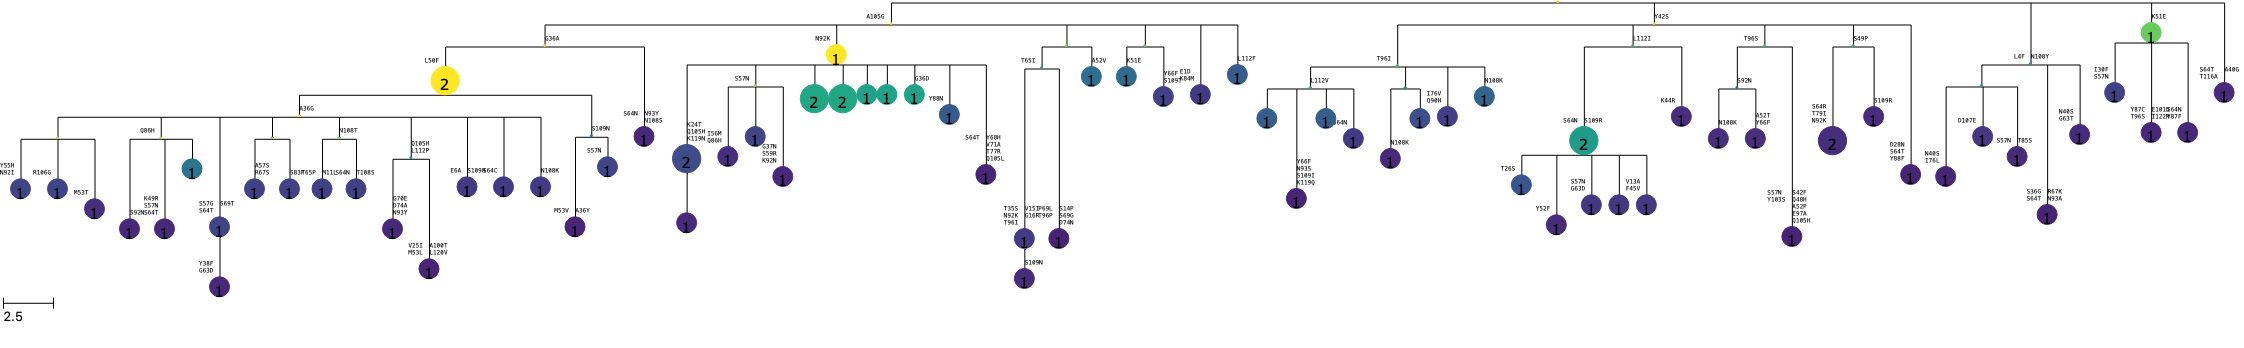

gc38HK-2


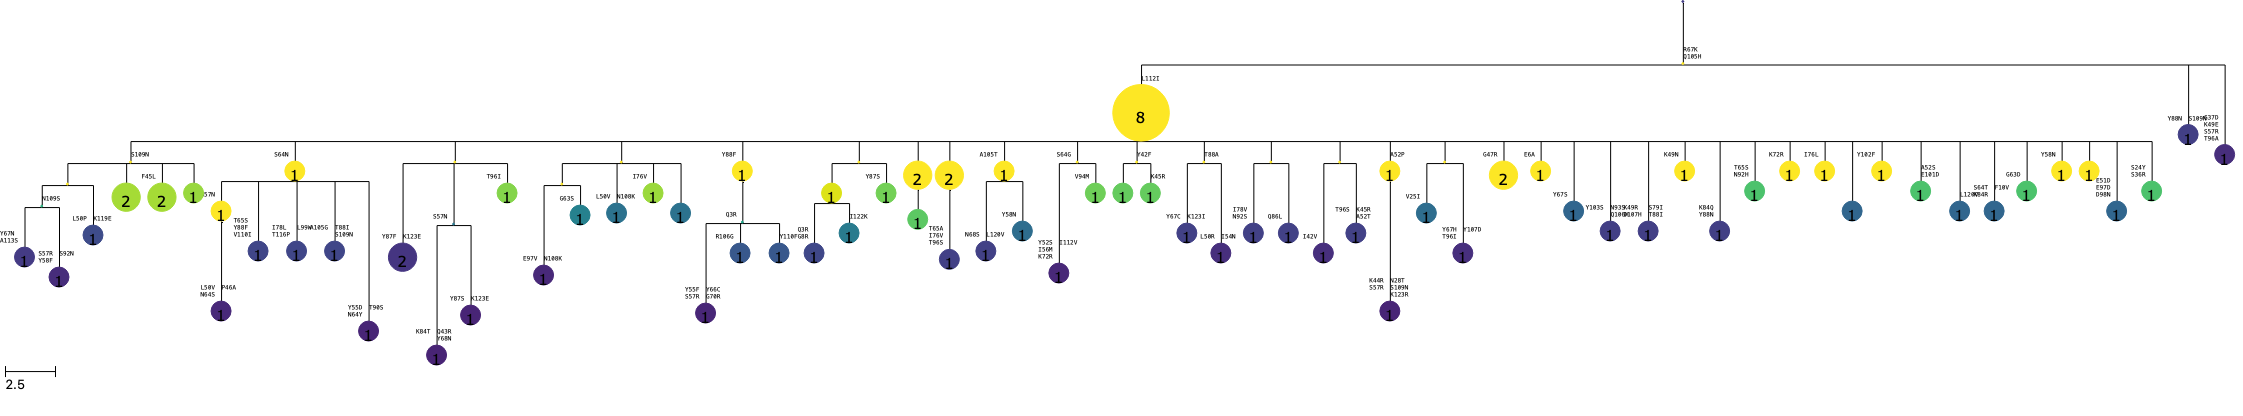

gc72HK-2


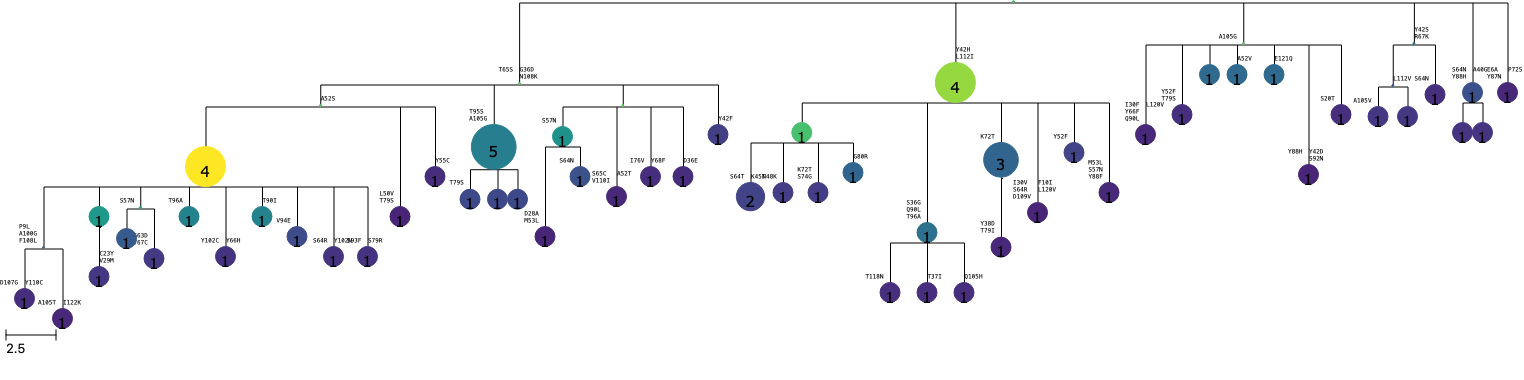

gc73HK-2


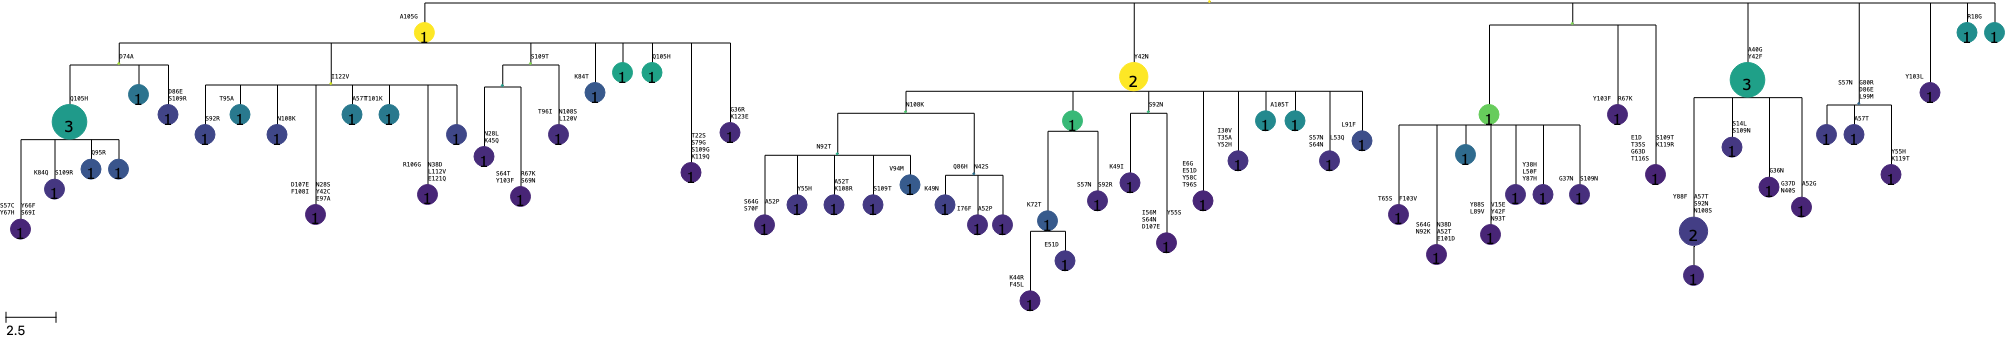

gc58HK-2


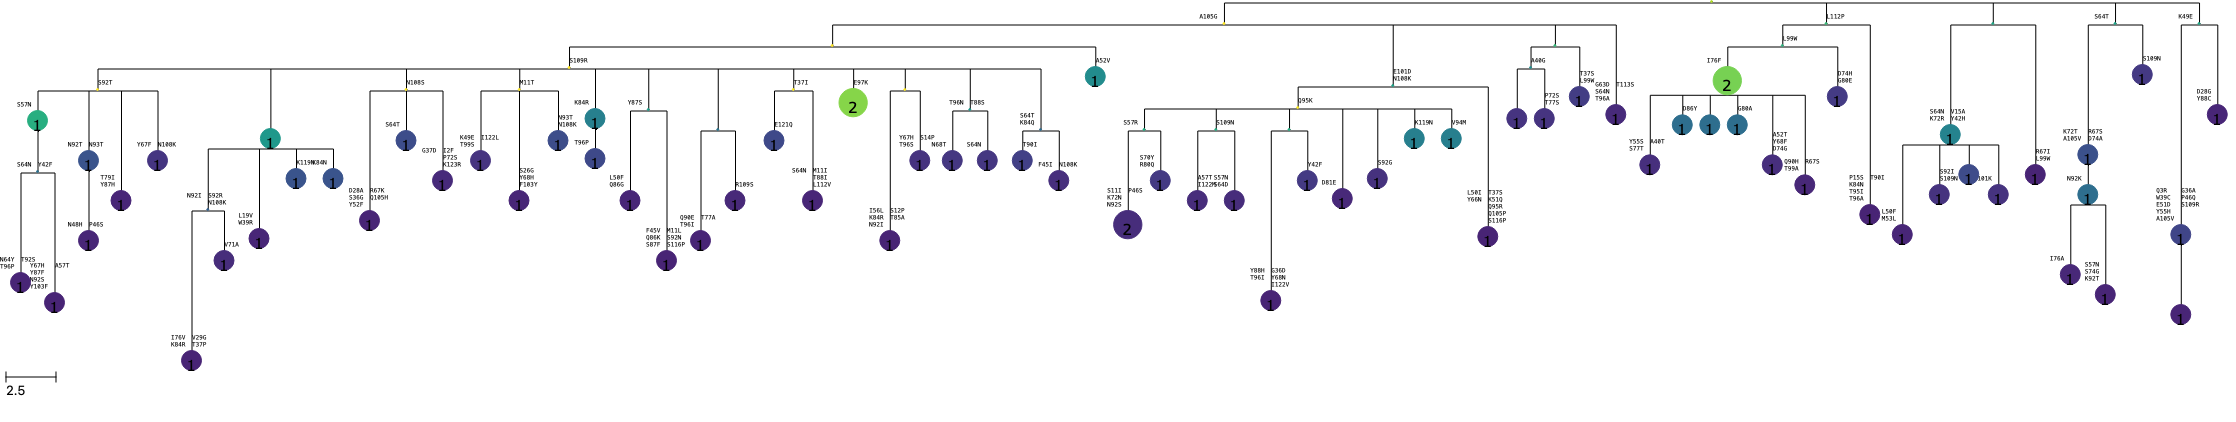

gc74HK-2


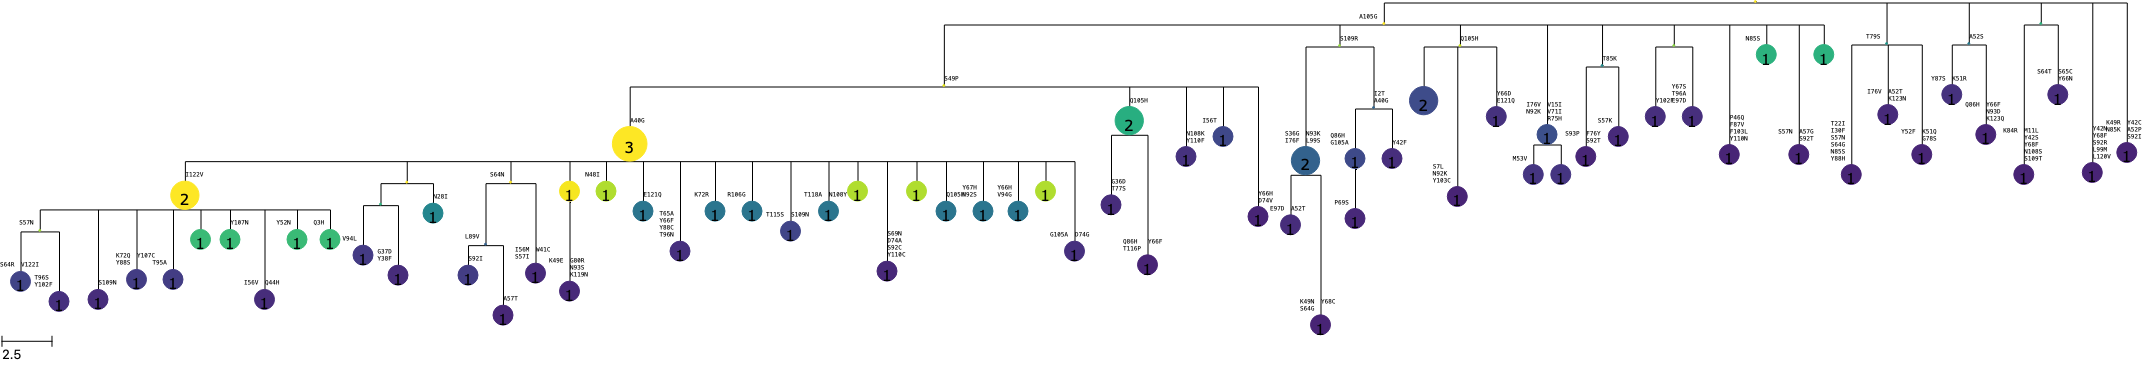

gc48HK-2


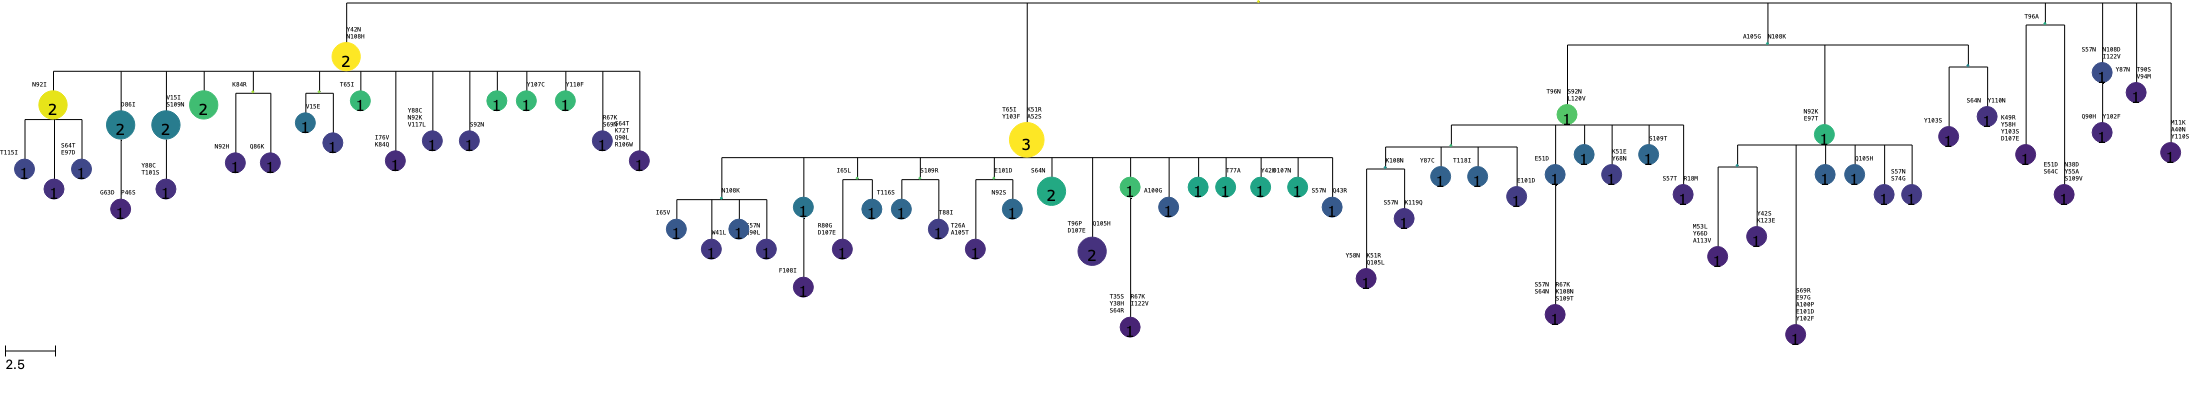

gc47HK-2


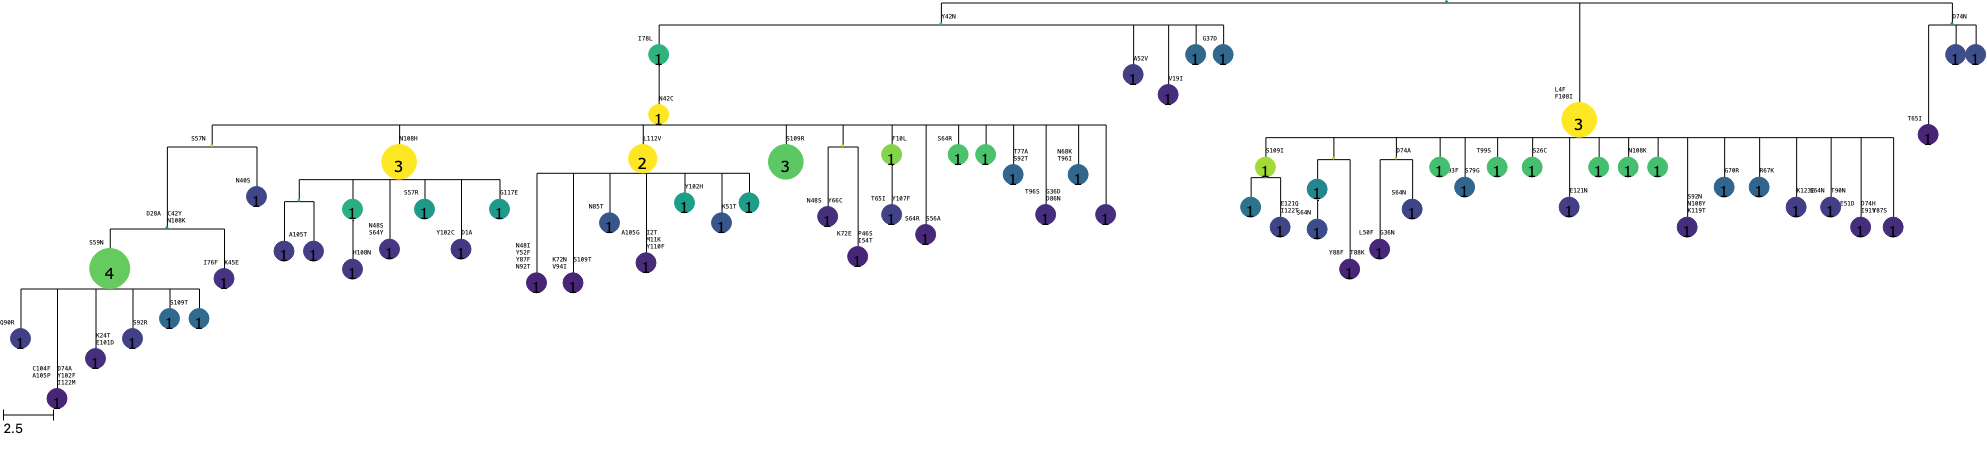

gc78HK-2


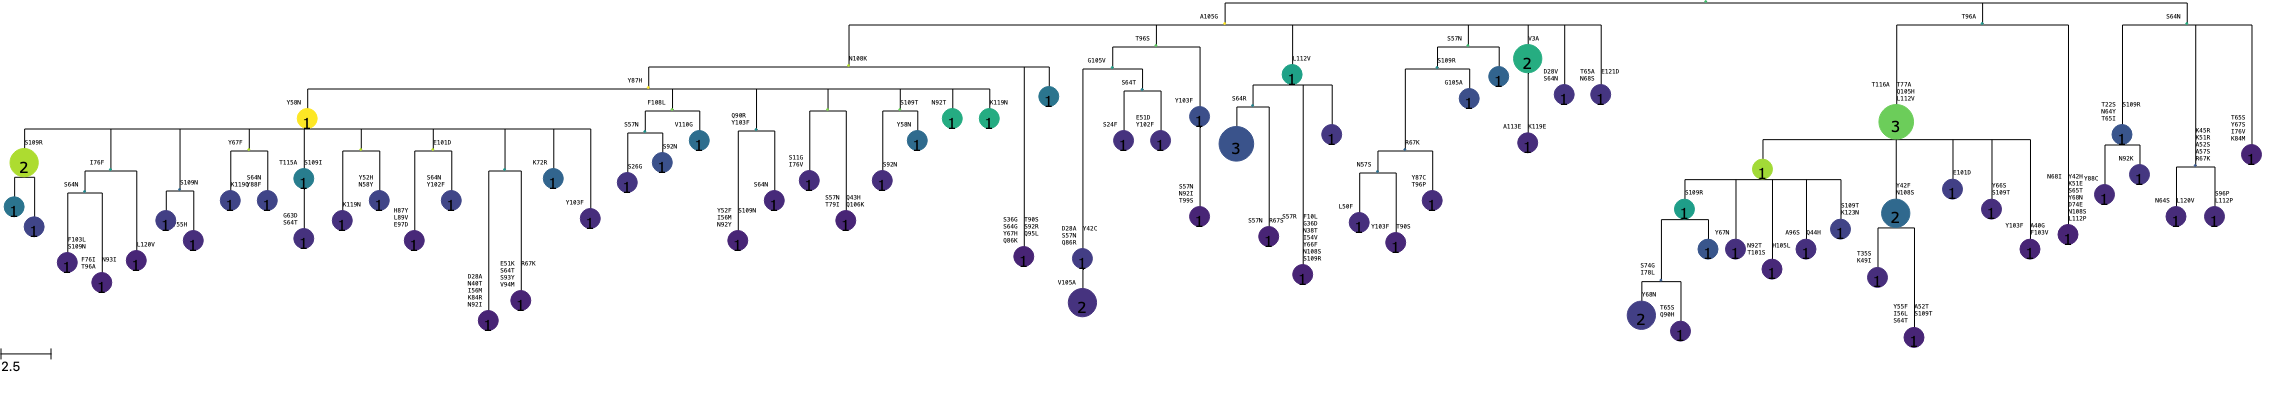

gc55HK-2


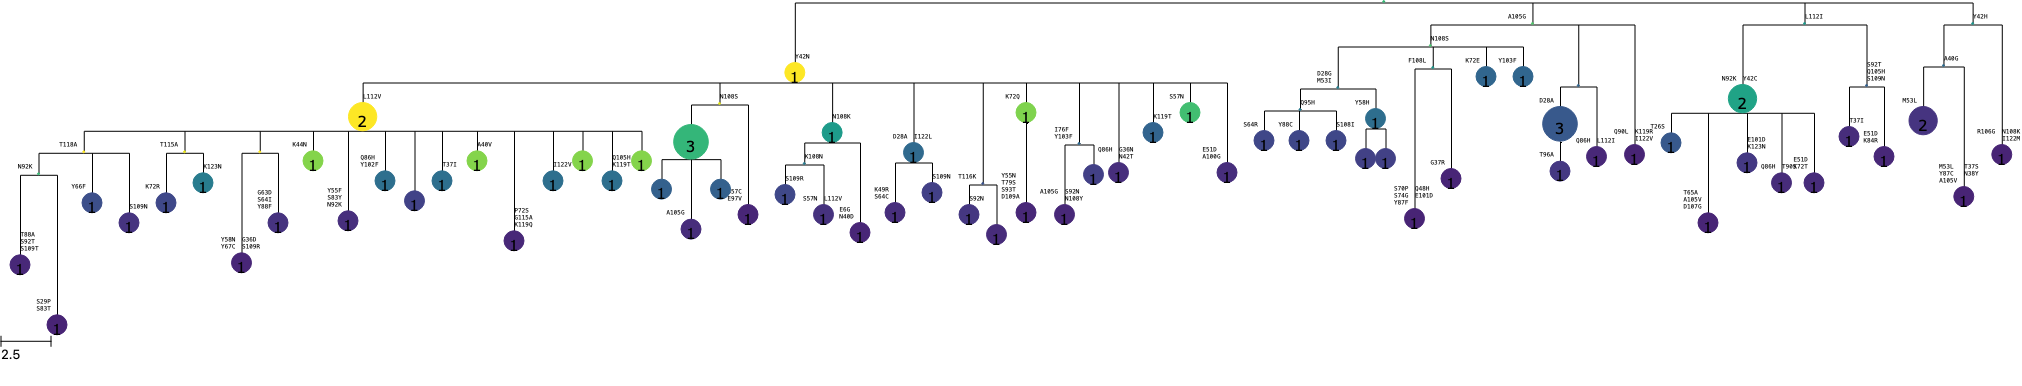

gc82HK-2


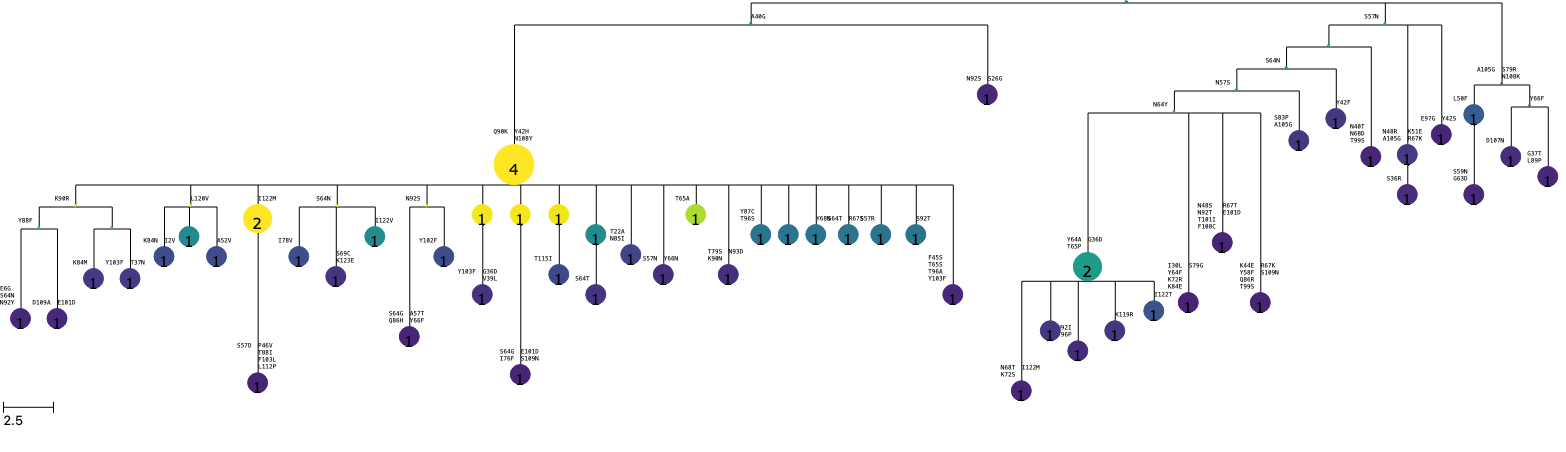

gc83HK-2


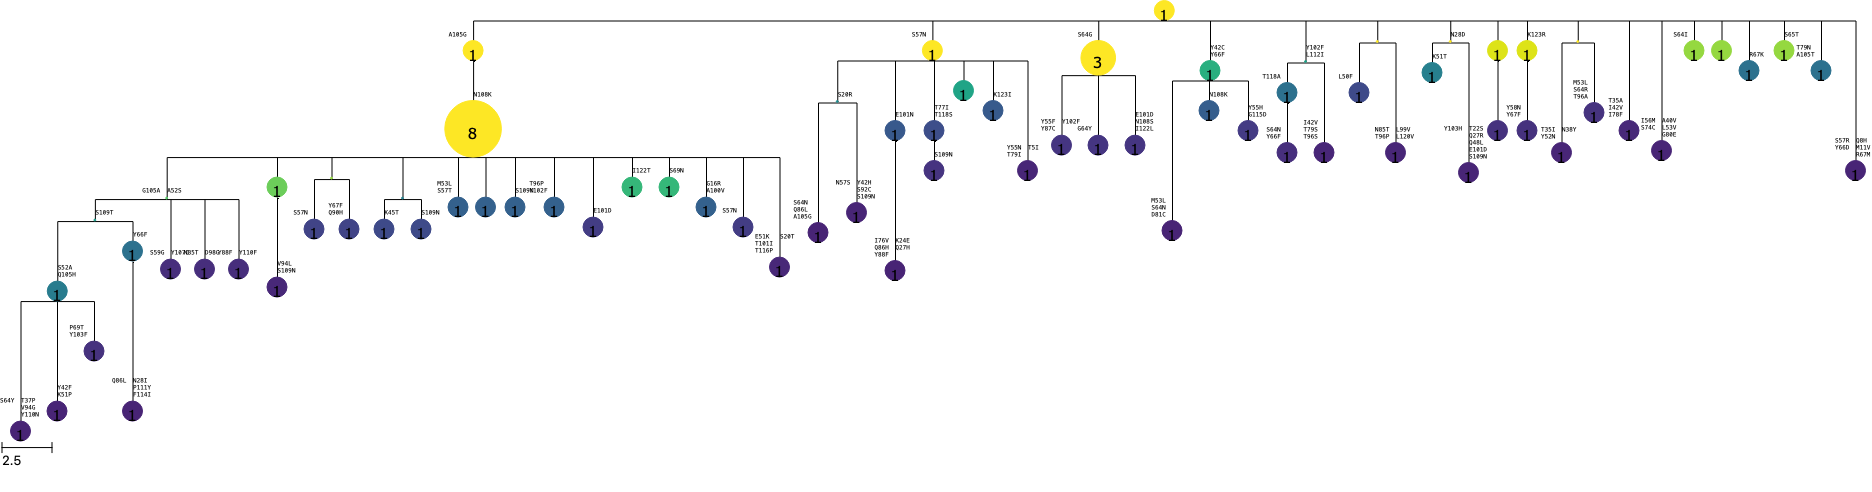

In [13]:
for gc, tree in trees.items():
    print(gc)
    local_branching(tree)
    
    cmap = cm.get_cmap("viridis")
    norm = Normalize(vmin=0, vmax=10)
    colormap = {node.name: to_hex(cmap(norm(node.LBI))) for node in tree.tree.traverse()}
    
    for file in (f"output/plots/colormapped_gctrees/{gc}.LBI.svg", "%%inline"):
        rendering = tree.render(file, scale=20,
                            colormap=colormap,
                            frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                            position_map=igh_pos_map.site, position_map2=igk_pos_map.site)
    display(rendering)

In [14]:
trees_df = pd.DataFrame()

for gc, tree in trees.items():
    
    # rename tuple names with last element of tuple (possible danger)
    if isinstance(tree.tree.name, tuple):
        tree.tree.name = tree.tree.name[-1]
    
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

    for node in tree.tree.traverse():
        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map.site, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map.site, "(L)")

        new_row = dms_df.loc[dms_df.mutation.isin(igh_mutations + igk_mutations), ["delta_bind", "delta_expr", "delta_psr"]].sum()
        new_row["GC"] = gc
        new_row["node"] = node.name
        new_row["parent"] = node.up.name if node.up is not None else None
        new_row["abundance"] = node.abundance
        new_row["branch length from naive"] = tree.tree.get_distance(node)
        new_row["LBI"] = node.LBI
        new_row["LBR"] = node.LBR

        trees_df = trees_df.append(new_row, ignore_index=True, verify_integrity=True)
        
trees_df.set_index(["GC", "node"], inplace=True)

trees_df.to_csv("output/integrated_data.csv")
trees_df

delta_bind  delta_expr  delta_psr parent  abundance  \
GC       node                                                         
gc31HK   naive     0.00000     0.00000    0.00000   None        0.0   
         15       -0.07276    -0.08096   -0.38447  naive        0.0   
         4        -0.01297    -0.10773   -0.20091  naive        0.0   
         5         0.33100    -0.00561   -0.27353  naive        0.0   
         6         0.75701    -0.53565    0.53716  naive        0.0   
...                    ...         ...        ...    ...        ...   
gc83HK-2 seq7      1.02962     0.06592    0.22230     14        1.0   
         seq58    -1.74805    -1.65148    2.52684  seq42        1.0   
         seq3      0.57016    -0.26490    2.53541   seq7        1.0   
         seq30    -0.60392    -2.14966    1.32374   seq7        1.0   
         seq28    -3.30400    -1.13774    0.39423   seq7        1.0   

                branch length from naive        LBI       LBR  
GC       node                                                  
gc31HK   naive                       0.0   9.226658       NaN  
         15                          2.0   4.995467  1.363759  
         4                           1.0   6.394071  0.588029  
         5                           1.0  11.321017  1.811684  
         6                           3.0   8.995503  5.381685  
...                                  ...        ...       ...  
gc83HK-2 seq7                        9.0   4.173093  2.413622  
         seq58                      14.0   1.002497  0.000000  
         seq3                       11.0   1.429431  0.000000  
         seq30                      14.0   1.021380  0.000000  
         seq28                      15.0   1.007865  0.000000  

[2840 rows x 8 columns]

In [140]:
mutability = pd.read_csv("mutability/MK_RS5NF_mutability.csv", index_col=0, squeeze=True)
substitution = pd.read_csv("mutability/MK_RS5NF_substitution.csv", index_col=0)

# mm = MutationModel("S5F/Mutability.csv", "S5F/Substitution.csv")
naive = tree.tree.sequence

def mutate(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

In [213]:
sim_df = pd.DataFrame()
replicate = 1
delta_expr_threshold = -0.5
fitness_transition = 10
while replicate < 100:
    print(f"replicate {replicate + 1}", end="   \r")
    sequence = naive
    n_mutations = 0
    rep_df = pd.DataFrame()
    dead = False
    while n_mutations < 11:
        if n_mutations:
            new_sequence = mutate(sequence)
        else:
            new_sequence = sequence
        igh_aa = aa(new_sequence[:igk_idx], igh_frame)
        igk_aa = aa(new_sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map.site, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map.site, "(L)")
        all_mutations = igh_mutations + igk_mutations
        new_row = dms_df.loc[dms_df.mutation.isin(all_mutations), ["delta_bind", "delta_expr", "delta_psr"]].sum()
        if np.random.rand() < expit(-fitness_transition * (new_row["delta_expr"] - delta_expr_threshold)):
            dead=True
            break
        sequence = new_sequence
        new_row["mutations"] = all_mutations
        new_row["n_mutations"] = n_mutations
        new_row["replicate"] = replicate
        rep_df = rep_df.append(new_row, ignore_index=True, verify_integrity=True)
        n_mutations += 1
    if not dead:
        sim_df = sim_df.append(rep_df, ignore_index=True, verify_integrity=True)
        replicate += 1
        
# sim_df.set_index(["GC", "node"], inplace=True)
sim_df

delta_bind  delta_expr  delta_psr  \
0        0.00000     0.00000    0.00000   
1        0.00000     0.00000    0.00000   
2       -0.04096    -0.02533   -0.04435   
3       -0.05557     0.01982    0.17097   
4        0.69914     0.03444    0.12231   
...          ...         ...        ...   
1084     0.02019    -0.01094   -0.04603   
1085    -0.00115    -0.09209   -0.18376   
1086     0.02589    -0.15570   -0.06082   
1087     0.02589    -0.15570   -0.06082   
1088     0.01576    -0.16826   -0.14870   

                                          mutations  n_mutations  replicate  
0                                                []          0.0        1.0  
1                                                []          1.0        1.0  
2                                         [S36(H)T]          2.0        1.0  
3                                 [L4(H)V, S36(H)T]          3.0        1.0  
4                       [L4(H)V, S36(H)T, S109(L)R]          4.0        1.0  
...                                             ...          ...        ...  
1084                                      [D86(L)N]          6.0       99.0  
1085                             [A52(L)T, D86(L)N]          7.0       99.0  
1086                    [V15(L)L, A52(L)T, D86(L)N]          8.0       99.0  
1087           [W39(H)*, V15(L)L, A52(L)T, D86(L)N]          9.0       99.0  
1088  [W39(H)*, Q90(H)H, V15(L)L, A52(L)T, D86(L)N]         10.0       99.0  

[1089 rows x 6 columns]

In [214]:
sim_df.delta_expr.min()

-0.7288399999999999

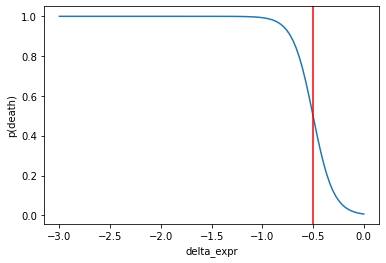

In [215]:
x = np.linspace(-3, 0, 100)
plt.plot(x, expit(-fitness_transition * (x - delta_expr_threshold)))
plt.axvline(delta_expr_threshold, c="r")
plt.xlabel("delta_expr")
plt.ylabel("p(death)")
plt.show()

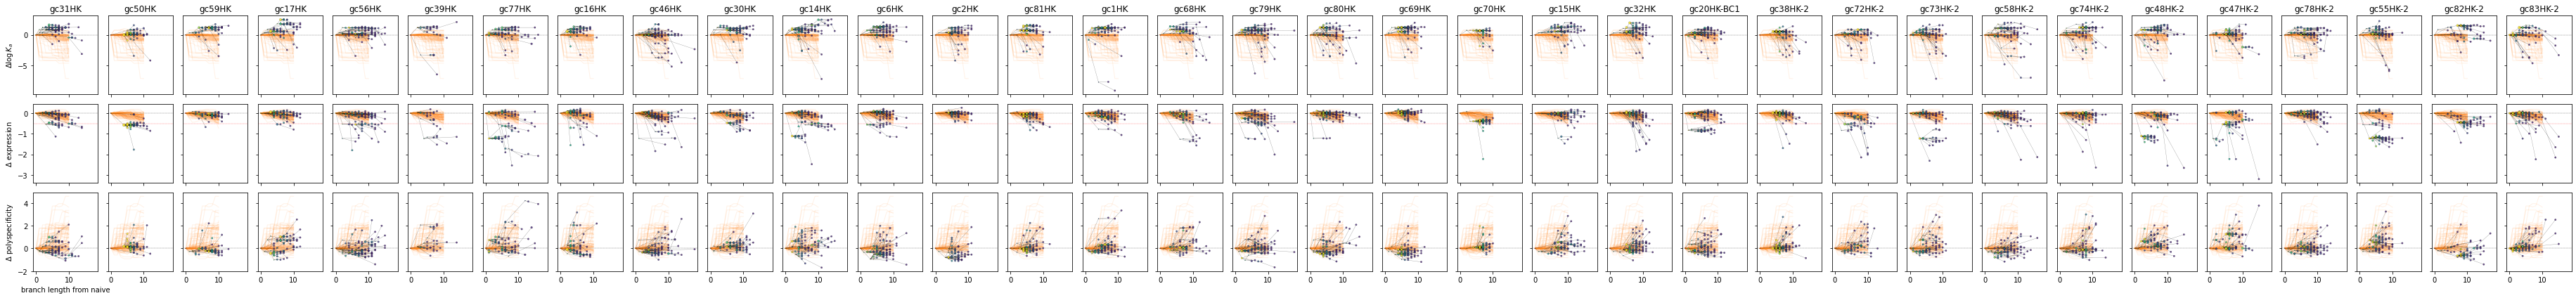

In [220]:
fig, axes = plt.subplots(3, len(trees), figsize=(1.5 * len(trees), 6), sharex=True, sharey="row")

for i, (phenotype, phenotype_label) in enumerate(zip(("delta_bind", "delta_expr", "delta_psr"),
                                                     (r"$\Delta \log K_a$", r"$\Delta$ expression", r"$\Delta$ polyspecificity"))):
    for j, (gc, tree) in enumerate(trees.items()):
        points = []
        lines = []
        colors = []
        
        for node in tree.tree.traverse():
            points.append((trees_df.loc[(gc, node.name), "branch length from naive"],
                           trees_df.loc[(gc, node.name), phenotype],
                           1 + 5 * np.sqrt(trees_df.loc[(gc, node.name), "abundance"]),
                           node.LBI))
            if node.up is not None:
                lines.append([(trees_df.loc[(gc, node.up.name), "branch length from naive"], trees_df.loc[(gc, node.up.name), phenotype]),
                              (trees_df.loc[(gc, node.name), "branch length from naive"], trees_df.loc[(gc, node.name), phenotype])])
            colors.append(node.LBI)

        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)

        ax = axes[i, j]
        ax.axhline(0, c="k", ls="--", lw=0.25, zorder=1)
        if phenotype == "delta_expr":
            ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        sns.lineplot(data=sim_df, x="n_mutations", y=phenotype, alpha=0.1,
                     legend=False, ax=ax,
                     units="replicate", ci=None, estimator=None,
                     zorder=2, color="C1", lw=1)
        ax.add_collection(lc)
        ax.scatter(*zip(*points), cmap=cmap, norm=norm, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4)
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
#         break
    axes[i, 0].set_ylabel(phenotype_label)
axes[-1, 0].set_xlabel("branch length from naive")
plt.tight_layout()
plt.savefig("output/plots/phenotype_trajectories.pdf")
plt.show()

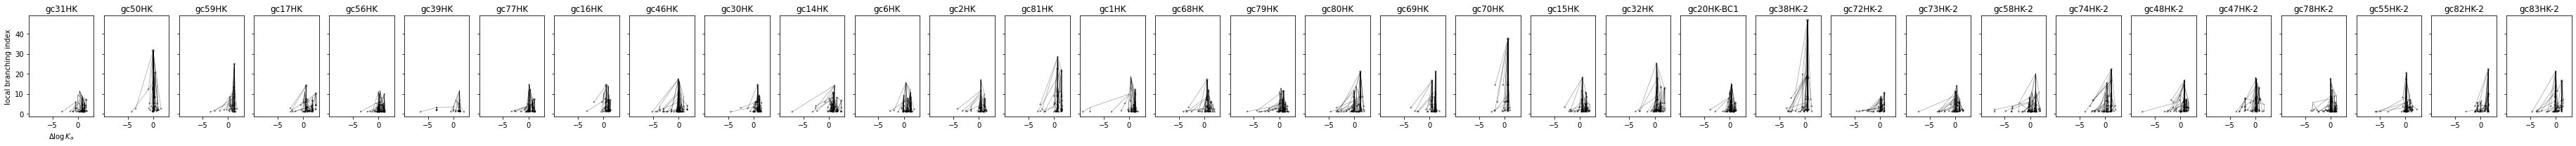

In [18]:
fig, axes = plt.subplots(1, len(trees), figsize=(1.5 * len(trees), 3), sharex=True, sharey="row")

for j, (gc, tree) in enumerate(trees.items()):
    points = []
    lines = []

    for node in tree.tree.traverse():
        points.append((trees_df.loc[(gc, node.name), "delta_bind"],
                       trees_df.loc[(gc, node.name), "LBI"],
                       1 + 5 * np.sqrt(trees_df.loc[(gc, node.name), "abundance"])))
        if node.up is not None:
            lines.append([(trees_df.loc[(gc, node.up.name), "delta_bind"], trees_df.loc[(gc, node.up.name), "LBI"]),
                          (trees_df.loc[(gc, node.name), "delta_bind"], trees_df.loc[(gc, node.name), "LBI"])])

    lc = mc.LineCollection(lines, colors="k", linewidths=0.5, alpha=0.5)

    ax = axes[j]
    ax.add_collection(lc)
    ax.scatter(*zip(*points), "k", alpha=0.5, edgecolors="none")
    ax.set_title(gc)
axes[0].set_xlabel(r"$\Delta \log K_a$")
axes[0].set_ylabel("local branching index")
plt.tight_layout()
plt.savefig("output/plots/LBI.pdf")
plt.show()

/var/folders/ty/cpxjst594js4kgnv59q14fk40000gp/T/ipykernel_51440/3678310473.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0, 'branch length from naive')

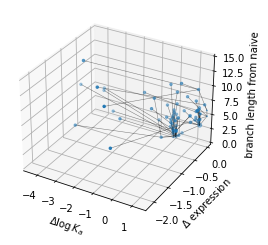

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

points = []
lines = []

for node in tree.tree.traverse():
    points.append((trees_df.loc[(gc, node.name), "delta_bind"],
                   trees_df.loc[(gc, node.name), "delta_expr"],
                   trees_df.loc[(gc, node.name), "branch length from naive"],
                   1 + 5 * np.sqrt(trees_df.loc[(gc, node.name), "abundance"])))
    if node.up is not None:
        lines.append([(trees_df.loc[(gc, node.up.name), "delta_bind"], trees_df.loc[(gc, node.up.name), "delta_expr"], trees_df.loc[(gc, node.up.name), "branch length from naive"]),
                      (trees_df.loc[(gc, node.name), "delta_bind"], trees_df.loc[(gc, node.name), "delta_expr"], trees_df.loc[(gc, node.name), "branch length from naive"])])

points = np.array(points)
        
lc = Line3DCollection(lines, colors="k", linewidths=0.5, alpha=0.5)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(points[:, 0].min(), points[:, 0].max())
ax.set_ylim(points[:, 1].min(), points[:, 1].max())
ax.set_zlim(points[:, 2].min(), points[:, 2].max())
ax.add_collection3d(lc)#, zs=z, zdir='z')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=points[:, 3])

ax.set_xlabel(r"$\Delta \log K_a$")
ax.set_ylabel(r"$\Delta$ expression")
ax.set_zlabel("branch length from naive")

# plt.savefig("output/plots/silly.pdf")

# ax = axes[i, j]
# ax.axhline(0, c="r", ls="--")
# ax.add_collection(lc)
# ax.scatter(*zip(*points), "k", alpha=0.5, edgecolors="none")


The top row above is especially impressive given the distribution of accessible affinity effects

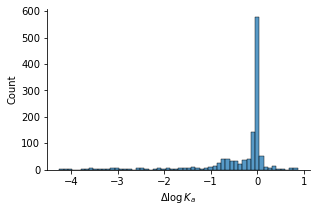

In [20]:
sns.displot(dms_df[(~dms_df.WT) & dms_df.single_nt], x="delta_bind", height=3, aspect=1.5)
plt.xlabel(r"$\Delta \log K_a$")
# plt.savefig("output/plots/silly2.pdf")
plt.show()

In [72]:
trees_df.index

MultiIndex([(  'gc31HK', 'naive'),
            (  'gc31HK',    '15'),
            (  'gc31HK',     '4'),
            (  'gc31HK',     '5'),
            (  'gc31HK',     '6'),
            (  'gc31HK',     '2'),
            (  'gc31HK', 'seq14'),
            (  'gc31HK', 'seq26'),
            (  'gc31HK', 'seq42'),
            (  'gc31HK',  'seq2'),
            ...
            ('gc83HK-2', 'seq41'),
            ('gc83HK-2', 'seq60'),
            ('gc83HK-2', 'seq55'),
            ('gc83HK-2',    '14'),
            ('gc83HK-2', 'seq42'),
            ('gc83HK-2',  'seq7'),
            ('gc83HK-2', 'seq58'),
            ('gc83HK-2',  'seq3'),
            ('gc83HK-2', 'seq30'),
            ('gc83HK-2', 'seq28')],
           names=['GC', 'node'], length=2840)

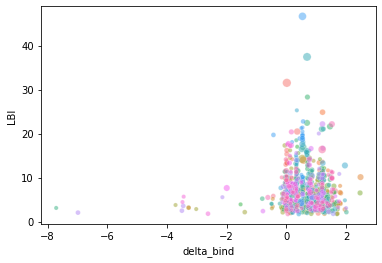

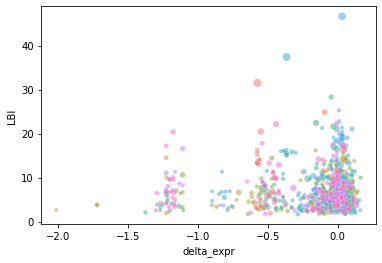

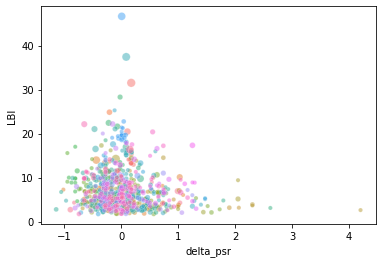

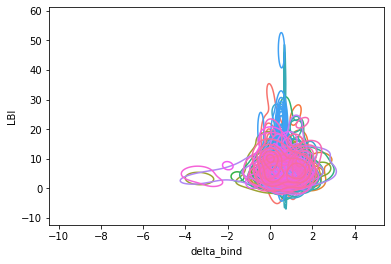

In [82]:
# ignore leaves and root
idxs = [(gc, node.name) for gc in trees for node in trees[gc].tree.traverse() if not node.is_leaf() and not node.is_root()]

plt.figure(figsize=(6, 4))
sns.scatterplot(data=trees_df.loc[idxs].reset_index(), x="delta_bind", y="LBI", hue="GC", size="abundance", alpha=0.5, legend=False)
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(data=trees_df.loc[idxs].reset_index(), x="delta_expr", y="LBI", hue="GC", size="abundance", alpha=0.5, legend=False)
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(data=trees_df.loc[idxs].reset_index(), x="delta_psr", y="LBI", hue="GC", size="abundance", alpha=0.5, legend=False)
plt.show()

plt.figure(figsize=(6, 4))
sns.kdeplot(data=trees_df.loc[idxs].reset_index(), x="delta_bind", y="LBI", hue="GC", legend=False)
plt.show()

# Distributions of affinity effects of mutations on trees

Let's look at phenotypic effects of *sitewise* first-step mutations. We can do this sitewise because we are using an additive model. This would also work with a global epistasis model, with an additive latent space.

In [66]:
def hit_counts(tree):
    node_generator = tree.tree.traverse()
    root = next(node)
    root.add_feature("hit counts", [0] * len(naive_igh_aa))
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
    for node in node_generator:
        igh_aa = aa(node.sequence[:igk_idx], igh_frame)
        igk_aa = aa(node.sequence[igk_idx:], igk_frame)

In [67]:
next(tree.tree.traverse())

Tree node '('seq26', 'naive')' (0x144635d9)

In [101]:
def mutation_effects(node):
    if node.up is None:
        return []
    naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
    naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
    parent_igh_aa = aa(node.up.sequence[:igk_idx], igh_frame)
    parent_igk_aa = aa(node.up.sequence[igk_idx:], igk_frame)
    parent_igh_mutations = mutations(naive_igh_aa, parent_igh_aa, igh_pos_map.site, "(H)")
    parent_igk_mutations = mutations(naive_igk_aa, parent_igk_aa, igk_pos_map.site, "(L)")
    parent_mutations = parent_igh_mutations + parent_igk_mutations
    
    igh_aa = aa(node.sequence[:igk_idx], igh_frame)
    igk_aa = aa(node.sequence[igk_idx:], igk_frame)
    igh_mutations = mutations(parent_igh_aa, igh_aa, igh_pos_map.site, "(H)")
    igk_mutations = mutations(parent_igk_aa, igk_aa, igk_pos_map.site, "(L)")
    node_mutations = igh_mutations + igk_mutations

    for mutation in node_mutations:
        match = [parent_mutation for parent_mutation in parent_mutations if parent_mutation[1:] == mutation[1:]]
#         dms_df.mutation[dms_df.mutation.str[1:] == mutation[1:]]
        assert len(match) < 2
        print(match)
        if len(match) = 0:
            effect = dms_df.delta_bind[dms_df.mutation == mutation].iloc[0]
            print(effect)
        else:
            print
#         print(mutation)
#         print(match)
    
#     print(parent_igh_mutations + parent_igk_mutations)
#     print(igh_mutations + igk_mutations)
    
#     sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()
    
    return 

In [102]:
for node in tree.tree.traverse():
    mutation_effects(node)

[]
-0.59898
[]
-4.04435
[]
0.03567
[]
-0.00503
[]
-0.01478
[]
0.00263
[]
-0.97242
[]
0.331
[]
-0.0086
[]
-0.04838
[]
-0.71399
[]
-0.04485
[]
-0.78621
[]
-0.27104
[]
0.86927
[]
0.02534
[]
-0.00335
[]
-0.15612
[]
0.03371
[]
0.34886
[]
-0.01042
[]
-0.09461
[]
-0.00685
[]
-0.01297
[]
0.86582
[]
-0.0881
[]
0.00551
[]
0.17986
[]
0.01564
[]
0.33206
[]
0.0188
[]
-0.05815
[]
-0.03494
[]
-0.03946
[]
-0.2854
[]
0.02465
[]
-0.04138
[]
0.005
[]
-0.00937
[]
-0.07037
[]
-0.00244
[]
-0.00153
[]
-0.017
[]
-2.98491
[]
-0.57422
[]
-0.27104
[]
0.02258
[]
-0.01913
[]
-0.05815
[]
0.68393
[]
0.01511
[]
-0.20324
[]
-2.60423
[]
0.03371
[]
-3.6806
[]
0.03003
[]
0.02323
[]
0.01201
[]
0.0172
[]
0.04376
[]
-0.03233
[]
-0.02832
[]
0.70794
[]
-0.01932
[]
0.331
[]
0.02258
[]
-0.02677
[]
-0.03494
[]


IndexError: single positional indexer is out-of-bounds

In [130]:
from collections import Counter
Counter(Counter(dms_df.mutation).values())

Counter({1: 4400, 10: 20, 3: 20, 4: 20})

In [190]:
bind_colormap(trees[0], vmin, vmax)

NameError: name 'trees' is not defined